In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import colorednoise as cn
import numpy as np

import ruptures as rpt

### Read data ###

In [2]:
interest_rates = pd.read_csv('Interest_rates.csv')
interest_rates['date'] = pd.to_datetime(interest_rates['date'], dayfirst=True)
interest_rates = interest_rates[interest_rates['date'] >= datetime.datetime(2021, 1, 1)]

train = interest_rates[(interest_rates['date'] < datetime.datetime(2024, 1, 1))]
test = interest_rates[interest_rates['date'] >= datetime.datetime(2024, 1, 1)]

### Generate colored noises ###

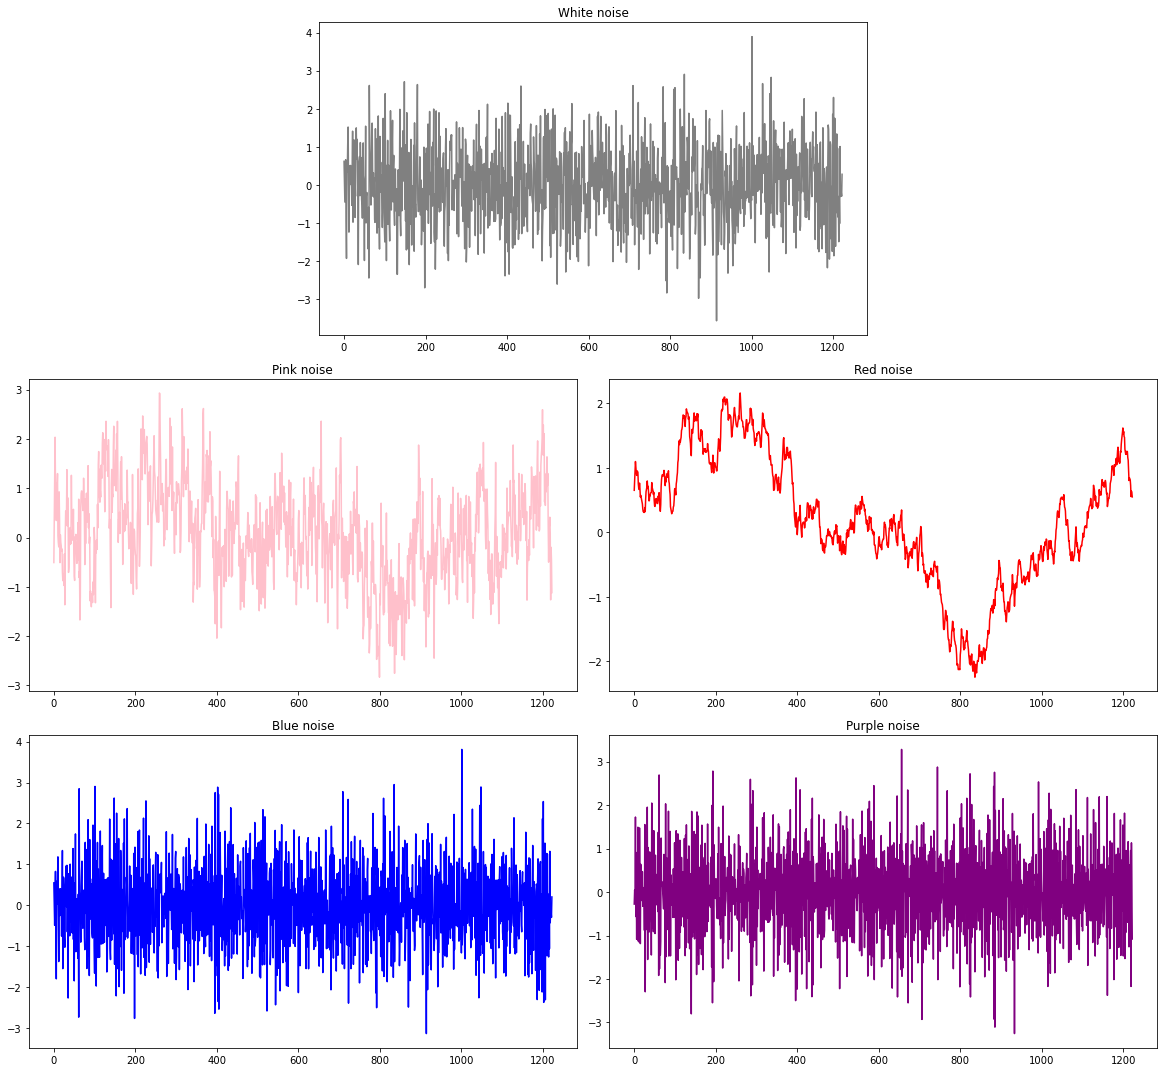

In [3]:
white_noise = cn.powerlaw_psd_gaussian(0, interest_rates.shape[0], random_state=11)
pink_noise = cn.powerlaw_psd_gaussian(1, interest_rates.shape[0], random_state=1)
red_noise = cn.powerlaw_psd_gaussian(2, interest_rates.shape[0], random_state=1)
blue_noise = cn.powerlaw_psd_gaussian(-1, interest_rates.shape[0], random_state=11)
purple_noise = cn.powerlaw_psd_gaussian(-2, interest_rates.shape[0], random_state=1)

fig = plt.figure(figsize=(20, 15),tight_layout=True)
spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)

ax1 = fig.add_subplot(spec[0,2:4])
ax2 = fig.add_subplot(spec[1,1:3])
ax3 = fig.add_subplot(spec[1,3:5])
ax4 = fig.add_subplot(spec[2,1:3])
ax5 = fig.add_subplot(spec[2,3:5])

ax1.plot(white_noise, color='grey')
ax1.title.set_text('White noise')
ax2.plot(pink_noise, color='pink')
ax2.title.set_text('Pink noise')
ax3.plot(red_noise, color='red')
ax3.title.set_text('Red noise')
ax4.plot(blue_noise, color='blue')
ax4.title.set_text('Blue noise')
ax5.plot(purple_noise, color='purple')
ax5.title.set_text('Purple noise')

plt.show()

### Parameters estimation for the CIR model (OLS method) ###

In [4]:
dt = 0.001

r = train['interest_rate'].to_numpy()
Y = np.diff(r)/np.sqrt(r[:-1])
Z = np.vstack((dt/np.sqrt(r[:-1]), dt*np.sqrt(r[:-1]))).T
betta_hat = np.linalg.lstsq(Z, Y, rcond=None)[0]

alpha = -betta_hat[1]
betta = betta_hat[0]/alpha
sigma = np.std(Y - Z @ betta_hat)/np.sqrt(dt * len(r))

print('alpha:', alpha)
print('betta:', betta)
print('sigma:', sigma)

alpha: 15.134138017067222
betta: 55.56421397833433
sigma: 0.07423650285141702


### Generate CIR timeseries for different colored noises ###

In [5]:
r_white = r[0]
r_pink = r[0]
r_red = r[0]
r_blue = r[0]
r_purple = r[0]

CIR_white = []
CIR_pink = []
CIR_red = []
CIR_blue = []
CIR_purple = []

for i in range(interest_rates.shape[0]):
    CIR_white.append(r_white)
    r_white = r_white + alpha * (betta - r_white) * dt + sigma * np.sqrt(r_white) * white_noise[i]

    CIR_pink.append(r_pink)
    r_pink = r_pink + alpha * (betta - r_pink) * dt + sigma * np.sqrt(r_pink) * pink_noise[i]

    CIR_red.append(r_red)
    r_red = r_red + alpha * (betta - r_red) * dt + sigma * np.sqrt(r_red) * red_noise[i]

    CIR_blue.append(r_blue)
    r_blue = r_blue + alpha * (betta - r_blue) * dt + sigma * np.sqrt(r_blue) * blue_noise[i]

    CIR_purple.append(r_purple)
    r_purple = r_purple + alpha * (betta - r_purple) * dt + sigma * np.sqrt(r_purple) * purple_noise[i]

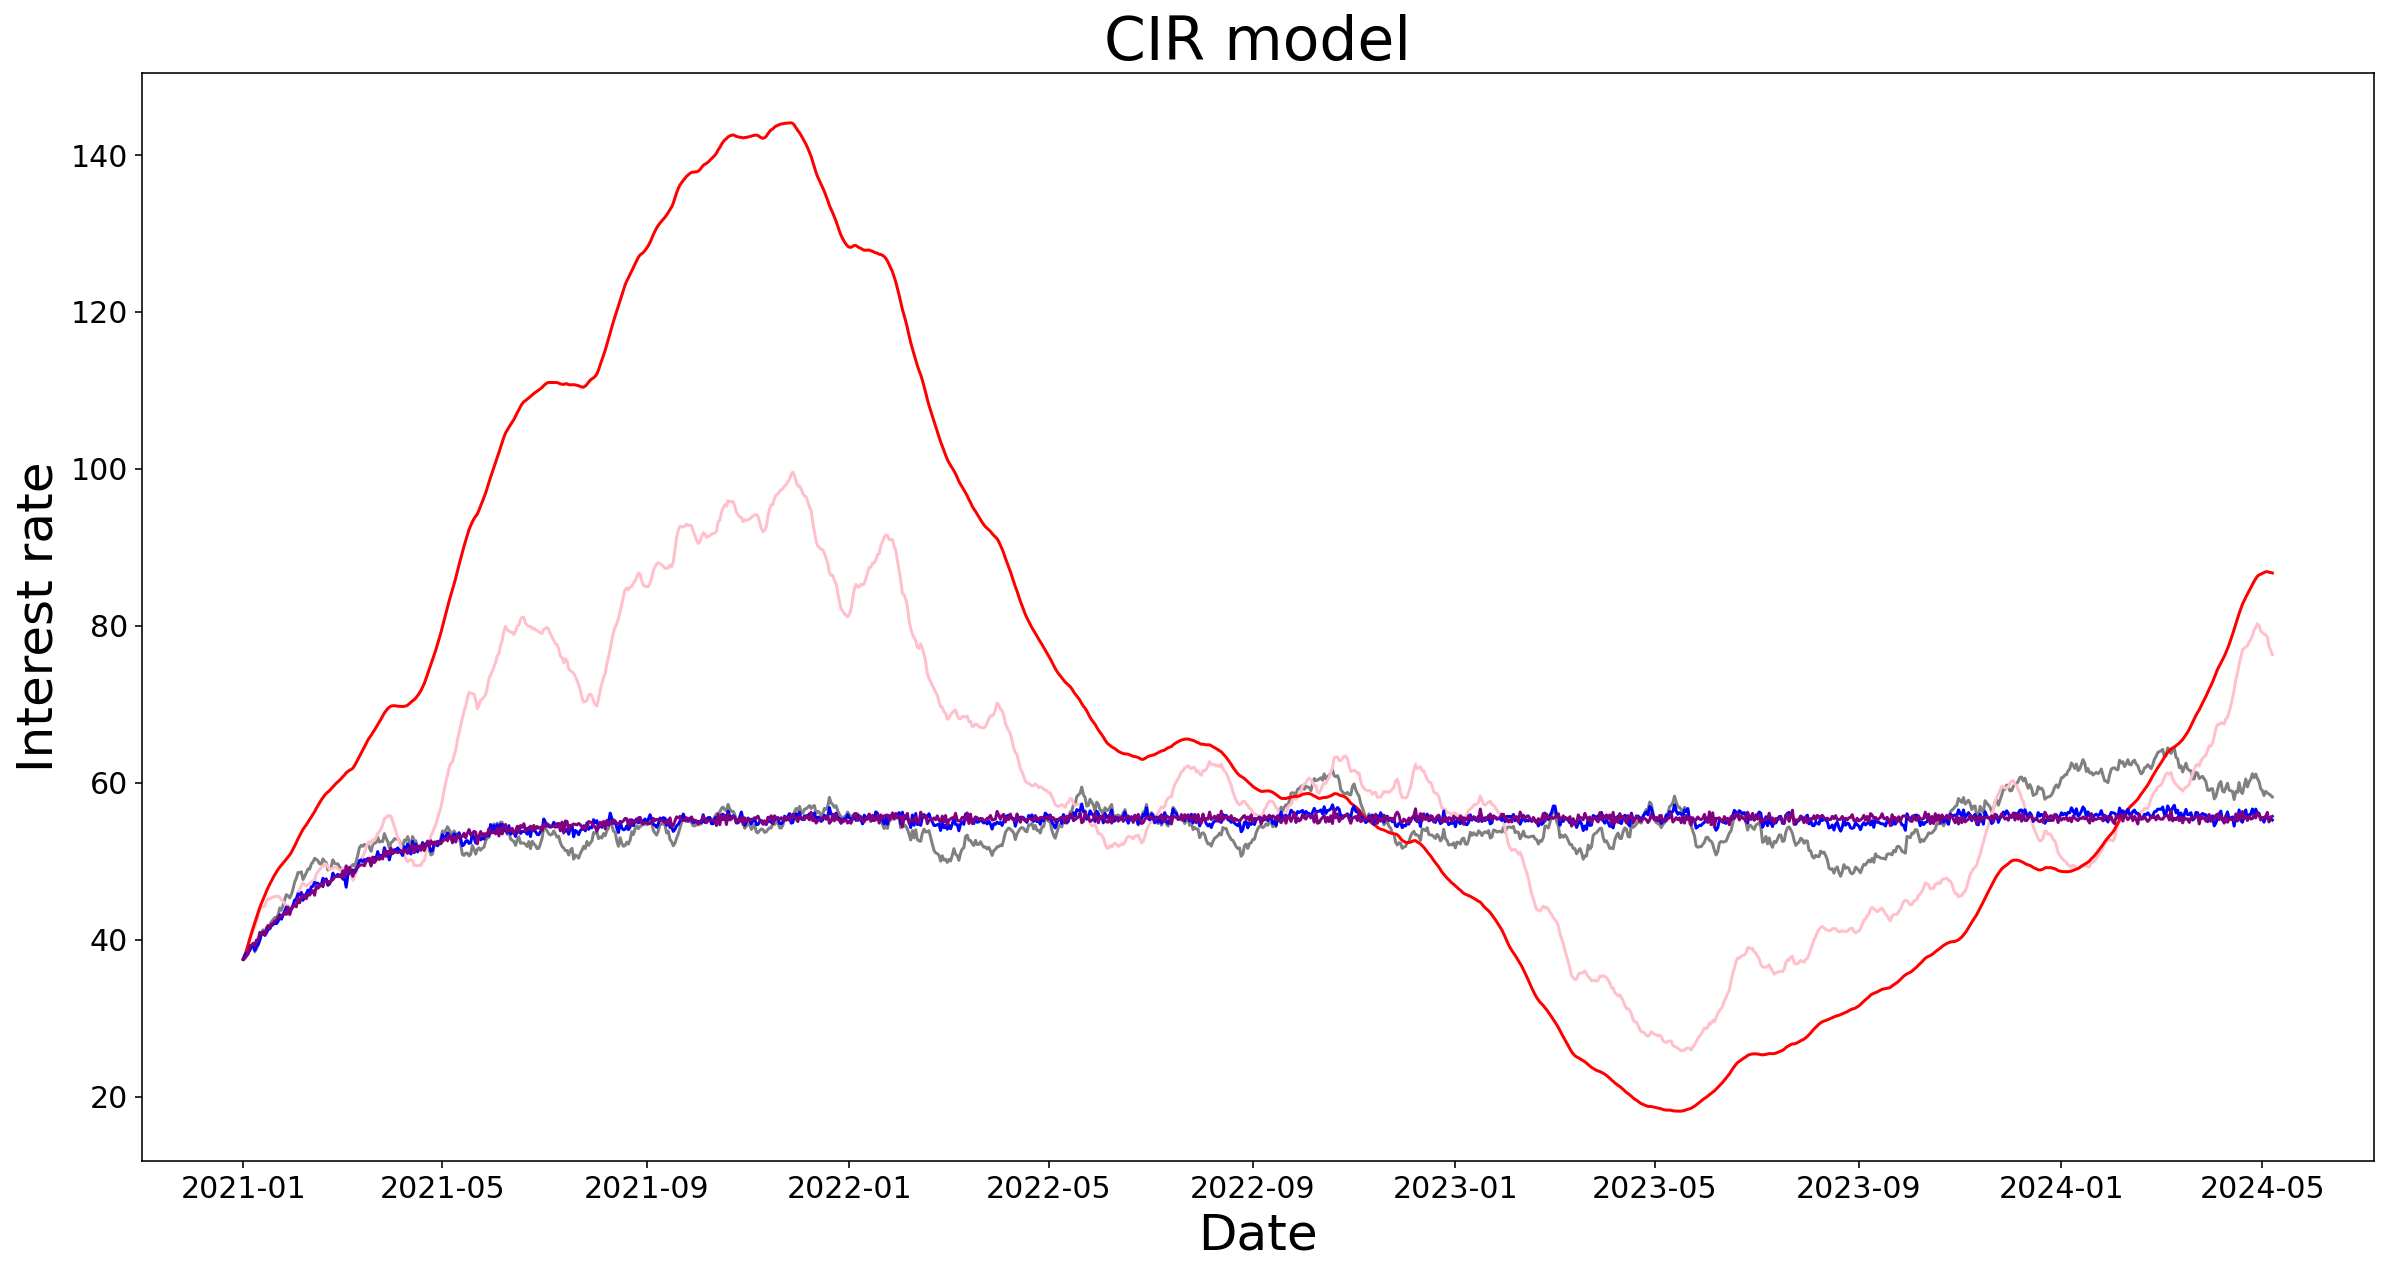

In [6]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10

plt.plot(interest_rates['date'], CIR_white, color='grey')
plt.plot(interest_rates['date'], CIR_pink, color='pink')
plt.plot(interest_rates['date'], CIR_red, color='red')
plt.plot(interest_rates['date'], CIR_blue, color='blue')
plt.plot(interest_rates['date'], CIR_purple, color='purple')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Interest rate", fontsize = 25)
plt.title("CIR model", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

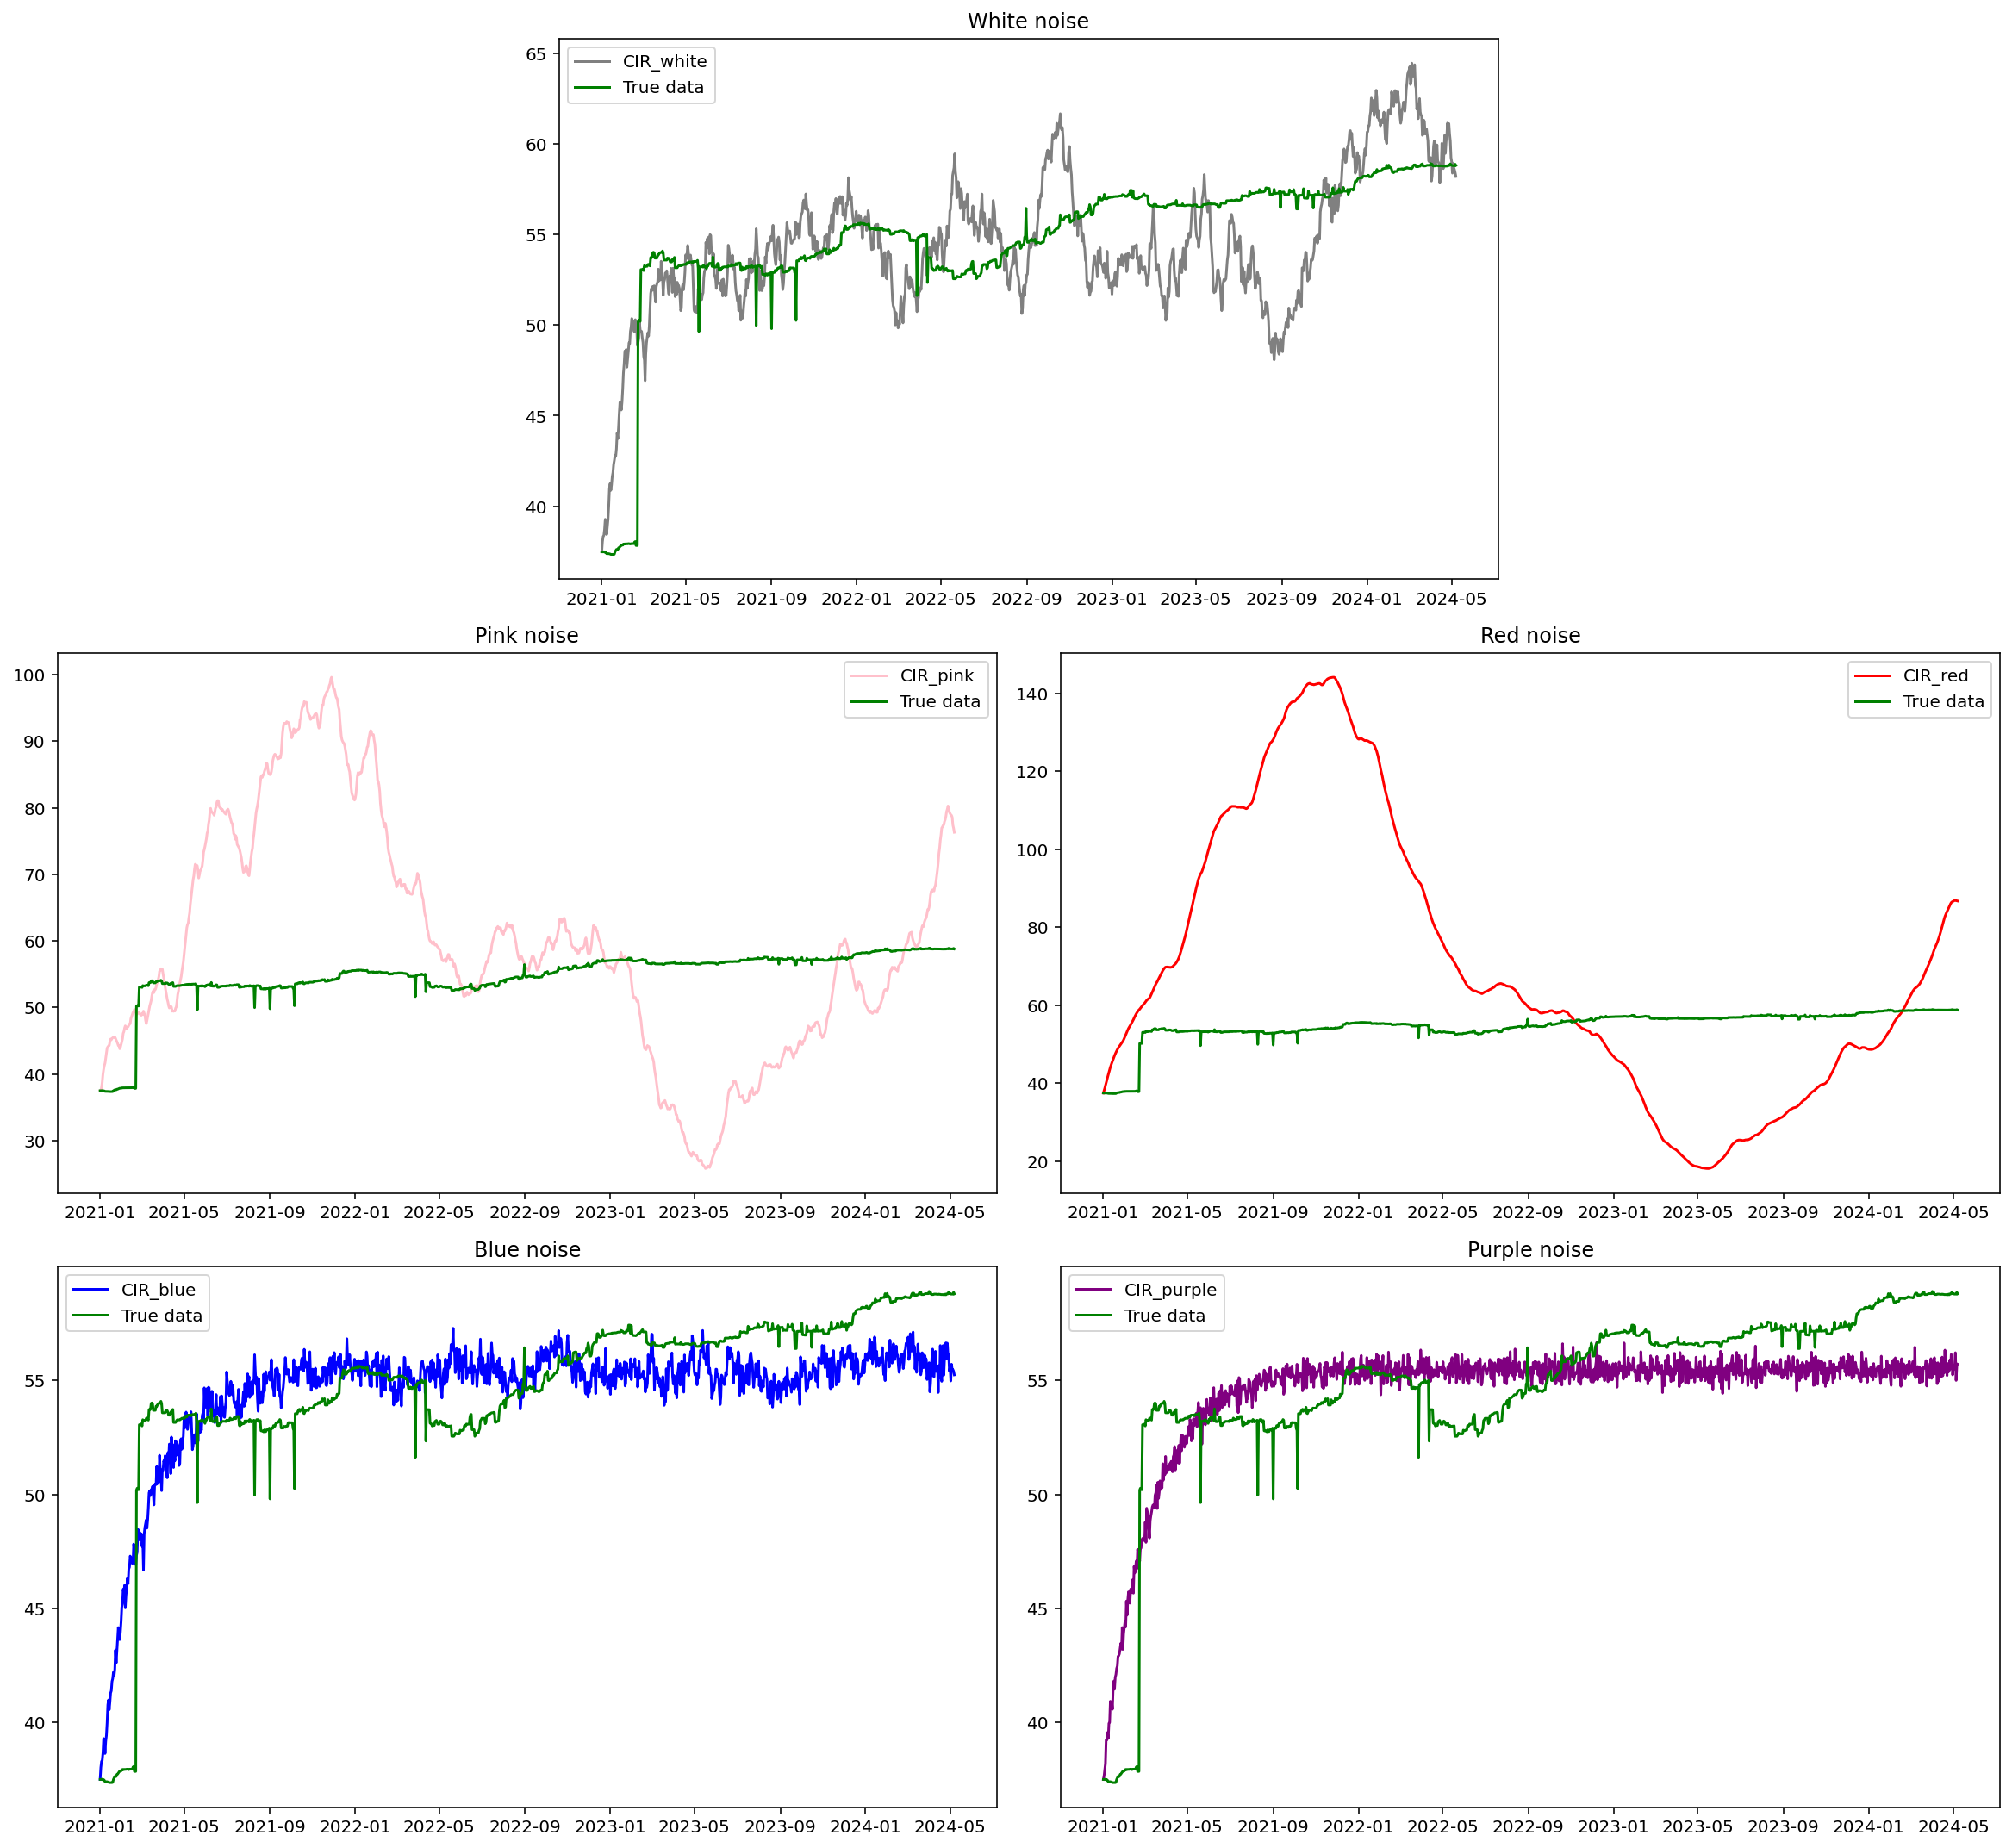

In [7]:
fig = plt.figure(figsize=(20, 15),tight_layout=True)
spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)

ax1 = fig.add_subplot(spec[0,2:4])
ax2 = fig.add_subplot(spec[1,1:3])
ax3 = fig.add_subplot(spec[1,3:5])
ax4 = fig.add_subplot(spec[2,1:3])
ax5 = fig.add_subplot(spec[2,3:5])

ax1.plot(interest_rates['date'], CIR_white, color='grey', label='CIR_white')
ax1.plot(interest_rates['date'], interest_rates['interest_rate'], color='green', label='True data')
ax1.legend()
ax1.title.set_text('White noise')

ax2.plot(interest_rates['date'], CIR_pink, color='pink', label='CIR_pink')
ax2.plot(interest_rates['date'], interest_rates['interest_rate'], color='green', label='True data')
ax2.legend()
ax2.title.set_text('Pink noise')

ax3.plot(interest_rates['date'], CIR_red, color='red', label='CIR_red')
ax3.plot(interest_rates['date'], interest_rates['interest_rate'], color='green', label='True data')
ax3.legend()
ax3.title.set_text('Red noise')

ax4.plot(interest_rates['date'], CIR_blue, color='blue', label='CIR_blue')
ax4.plot(interest_rates['date'], interest_rates['interest_rate'], color='green', label='True data')
ax4.legend()
ax4.title.set_text('Blue noise')

ax5.plot(interest_rates['date'], CIR_purple, color='purple', label='CIR_purple')
ax5.plot(interest_rates['date'], interest_rates['interest_rate'], color='green', label='True data')
ax5.legend()
ax5.title.set_text('Purple noise')

plt.show()

### PELT algorithm ###

#### White noise ####

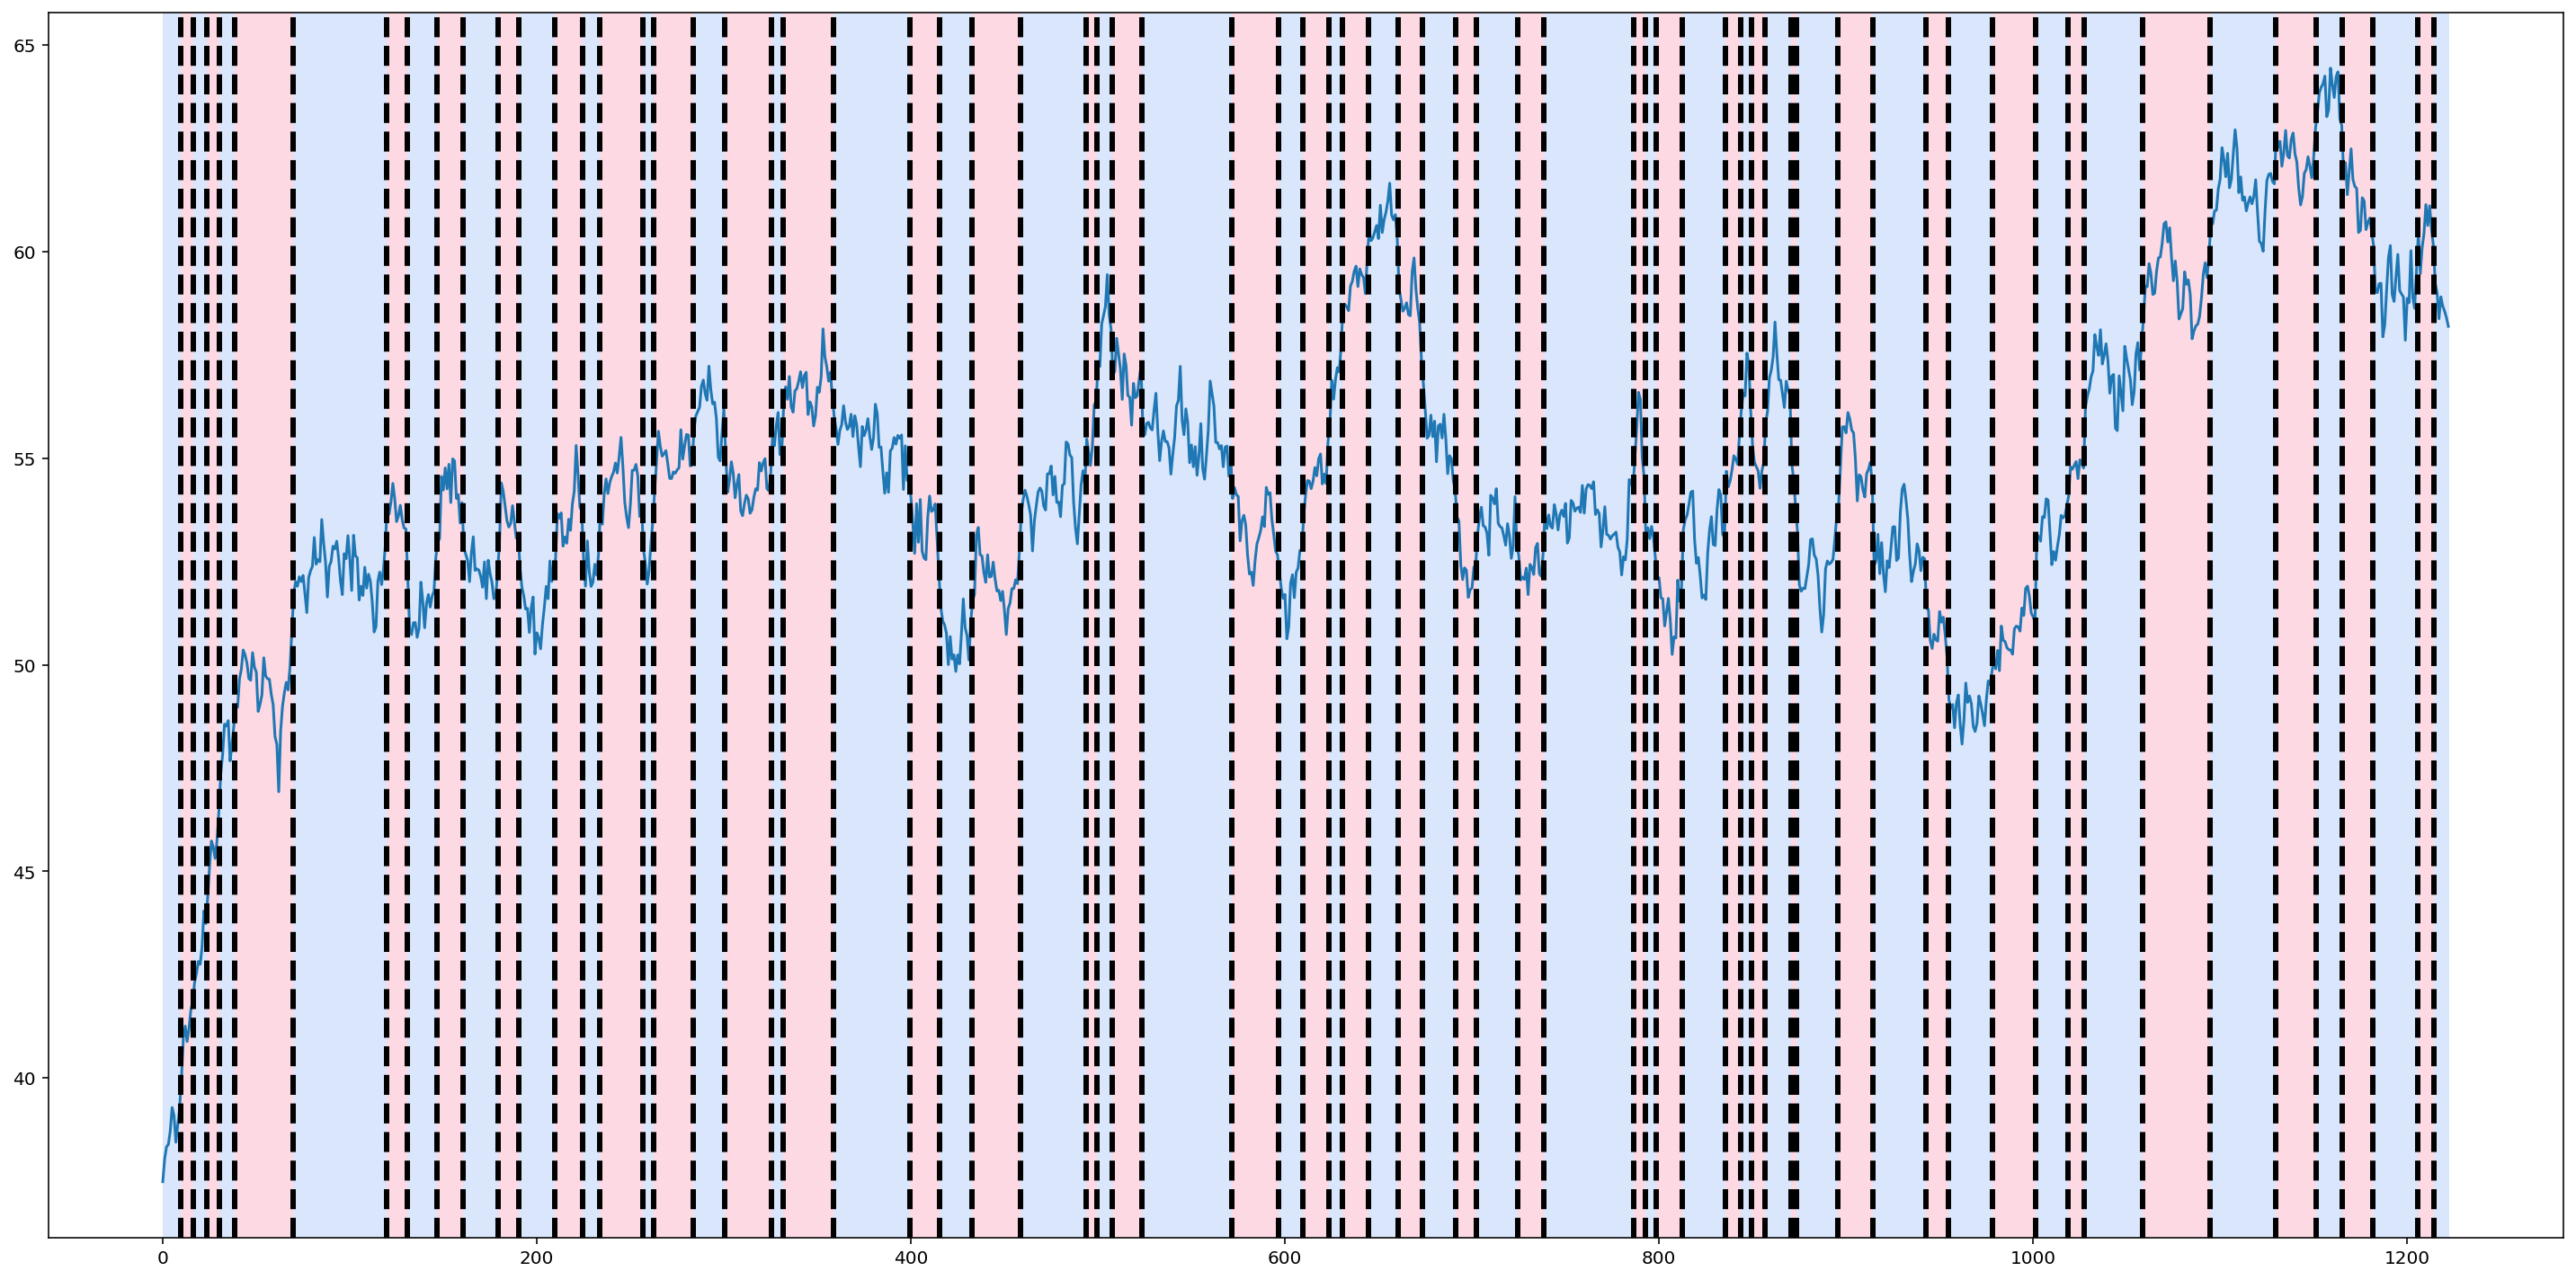

In [8]:
model = "rbf"  # "l1", "l2"
algo_white = rpt.Pelt(model=model, jump=1).fit(np.array(CIR_white))
bkps_white = algo_white.predict(pen=1)

fig = rpt.display(np.array(CIR_white), bkps_white, bkps_white, figsize=(20, 10))

if bkps_white[-1] == interest_rates.shape[0]:
    bkps_white = bkps_white[:-1]

bkps_white_ = [0] * interest_rates.shape[0]
for i in bkps_white:
    bkps_white_[i] = 1
CIR_white_data = pd.DataFrame(list(zip(interest_rates['date'], CIR_white, bkps_white_)), columns=['date', 'interest_rate', 'breakpoint'])

plt.show()

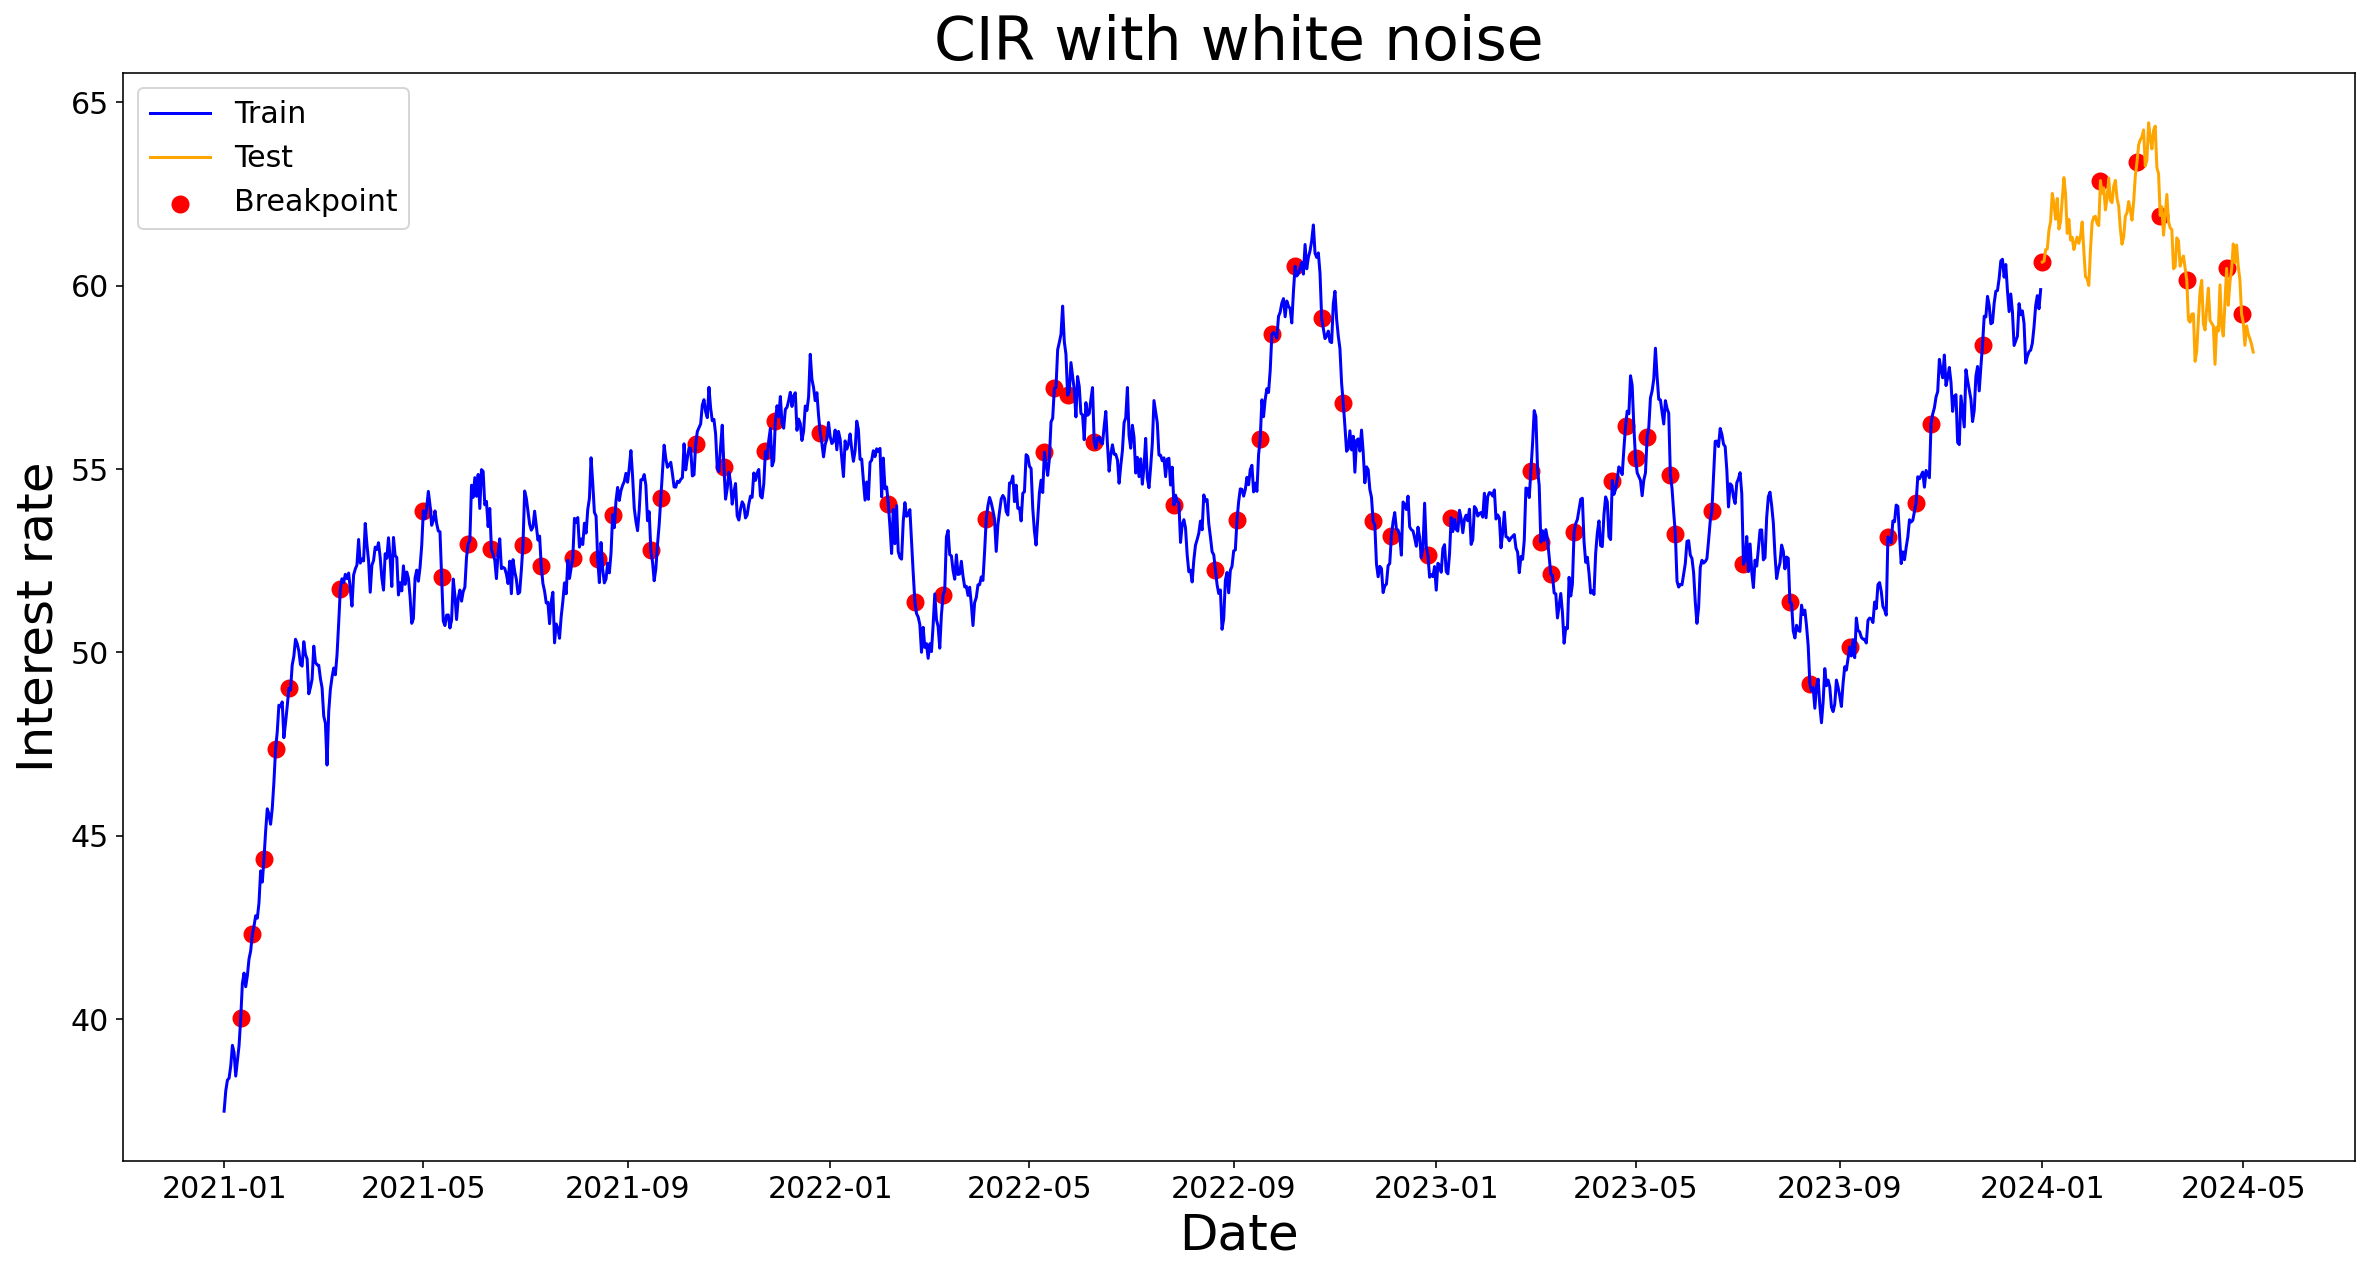

In [9]:
plt.scatter(CIR_white_data[CIR_white_data['breakpoint'] == 1]['date'], CIR_white_data[CIR_white_data['breakpoint'] == 1]['interest_rate'], color='red', linewidths=3, label='Breakpoint')
plt.plot(train['date'], CIR_white[:train.shape[0]], color='blue', label='Train')
plt.plot(test['date'], CIR_white[train.shape[0]:], color='orange', label='Test')
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('CIR with white noise', fontsize = 30)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

#### Pink noise ####

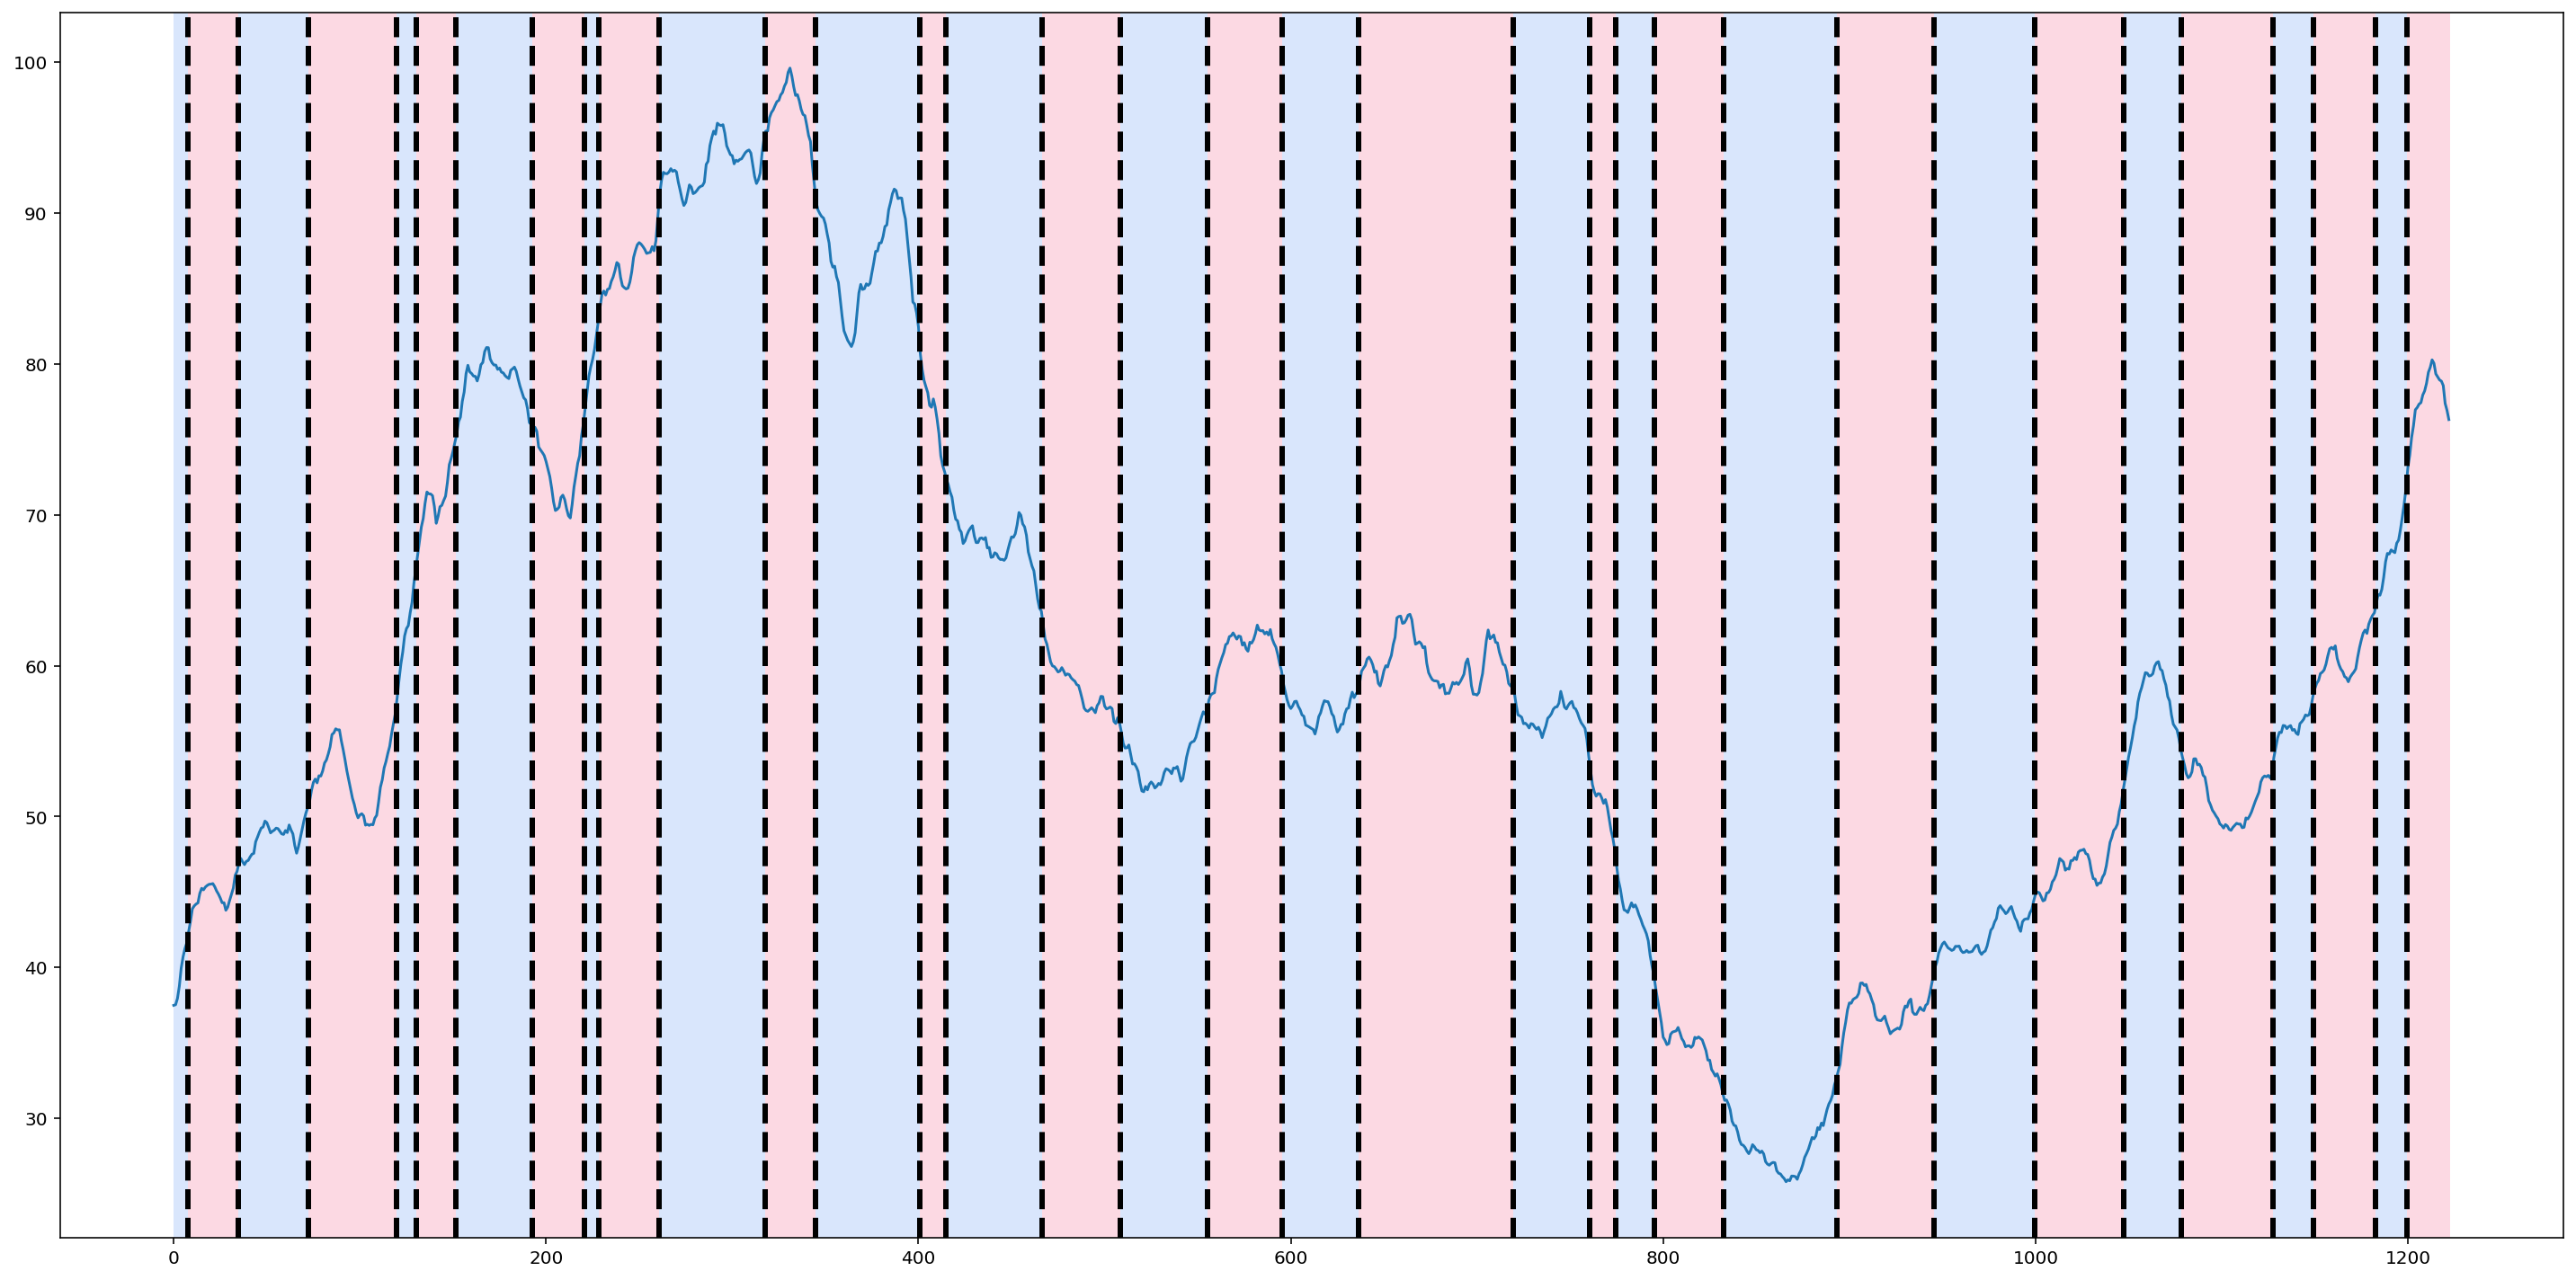

In [10]:
model = "rbf"  # "l1", "l2"
algo_pink = rpt.Pelt(model=model, jump=1).fit(np.array(CIR_pink))
bkps_pink = algo_pink.predict(pen=1)

fig = rpt.display(np.array(CIR_pink), bkps_pink, bkps_pink, figsize=(20, 10))

if bkps_pink[-1] == interest_rates.shape[0]:
    bkps_pink = bkps_pink[:-1]

bkps_pink_ = [0] * interest_rates.shape[0]
for i in bkps_pink:
    bkps_pink_[i] = 1
CIR_pink_data = pd.DataFrame(list(zip(interest_rates['date'], CIR_pink, bkps_pink_)), columns=['date', 'interest_rate', 'breakpoint'])

plt.show()

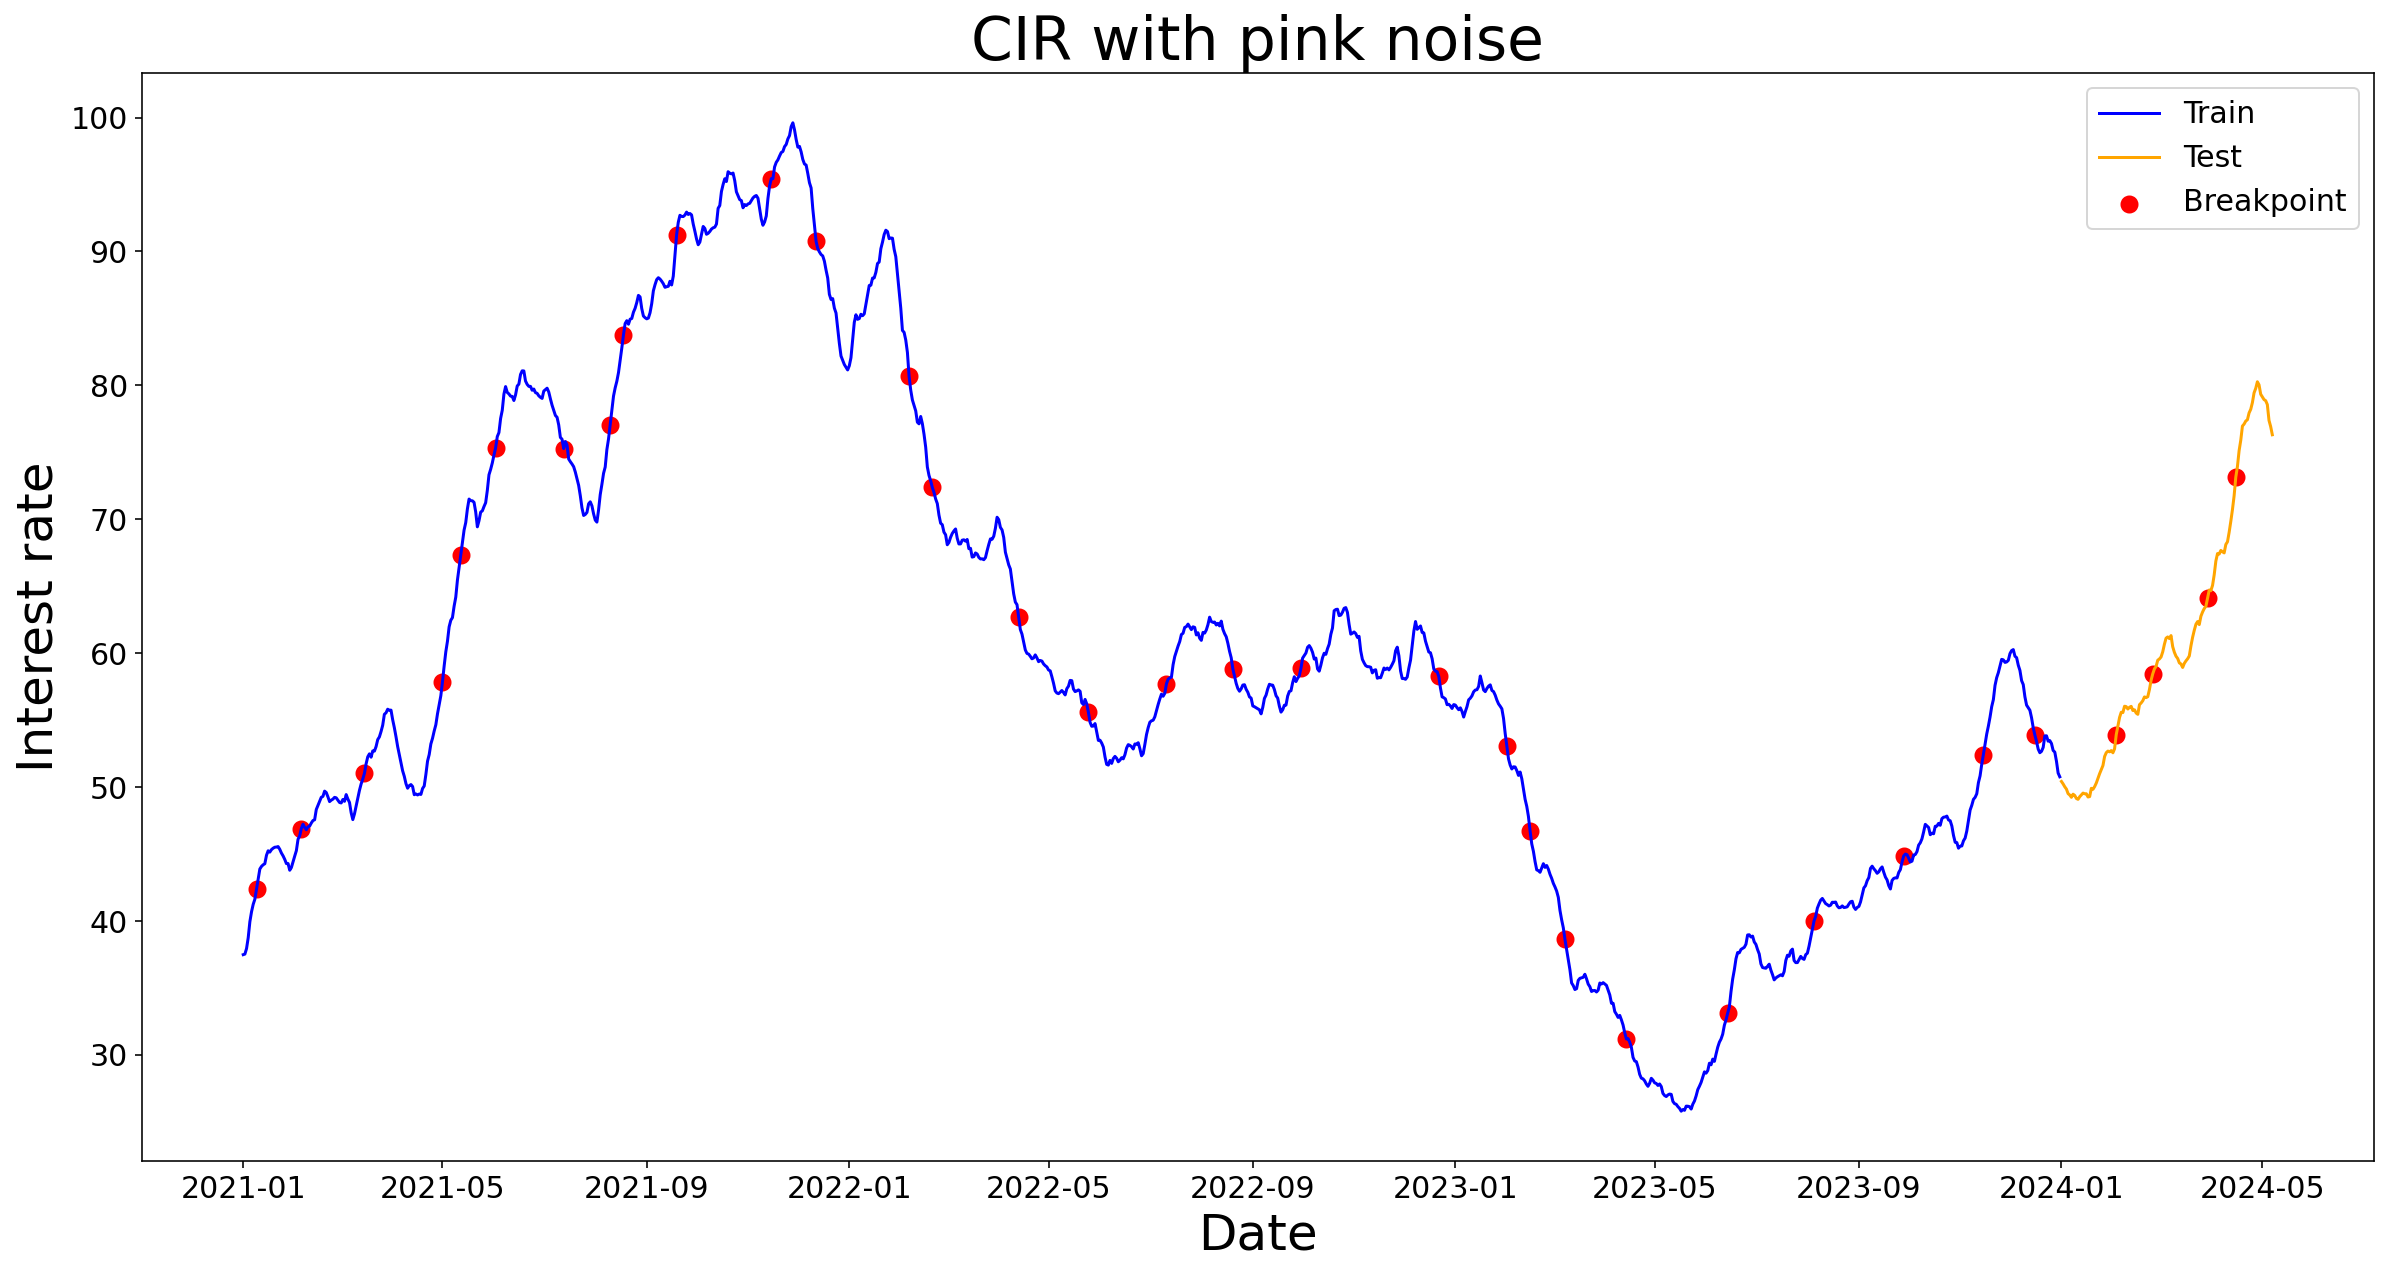

In [11]:
plt.scatter(CIR_pink_data[CIR_pink_data['breakpoint'] == 1]['date'], CIR_pink_data[CIR_pink_data['breakpoint'] == 1]['interest_rate'], color='red', linewidths=3, label='Breakpoint')
plt.plot(train['date'], CIR_pink[:train.shape[0]], color='blue', label='Train')
plt.plot(test['date'], CIR_pink[train.shape[0]:], color='orange', label='Test')
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('CIR with pink noise', fontsize = 30)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

#### Red noise ####

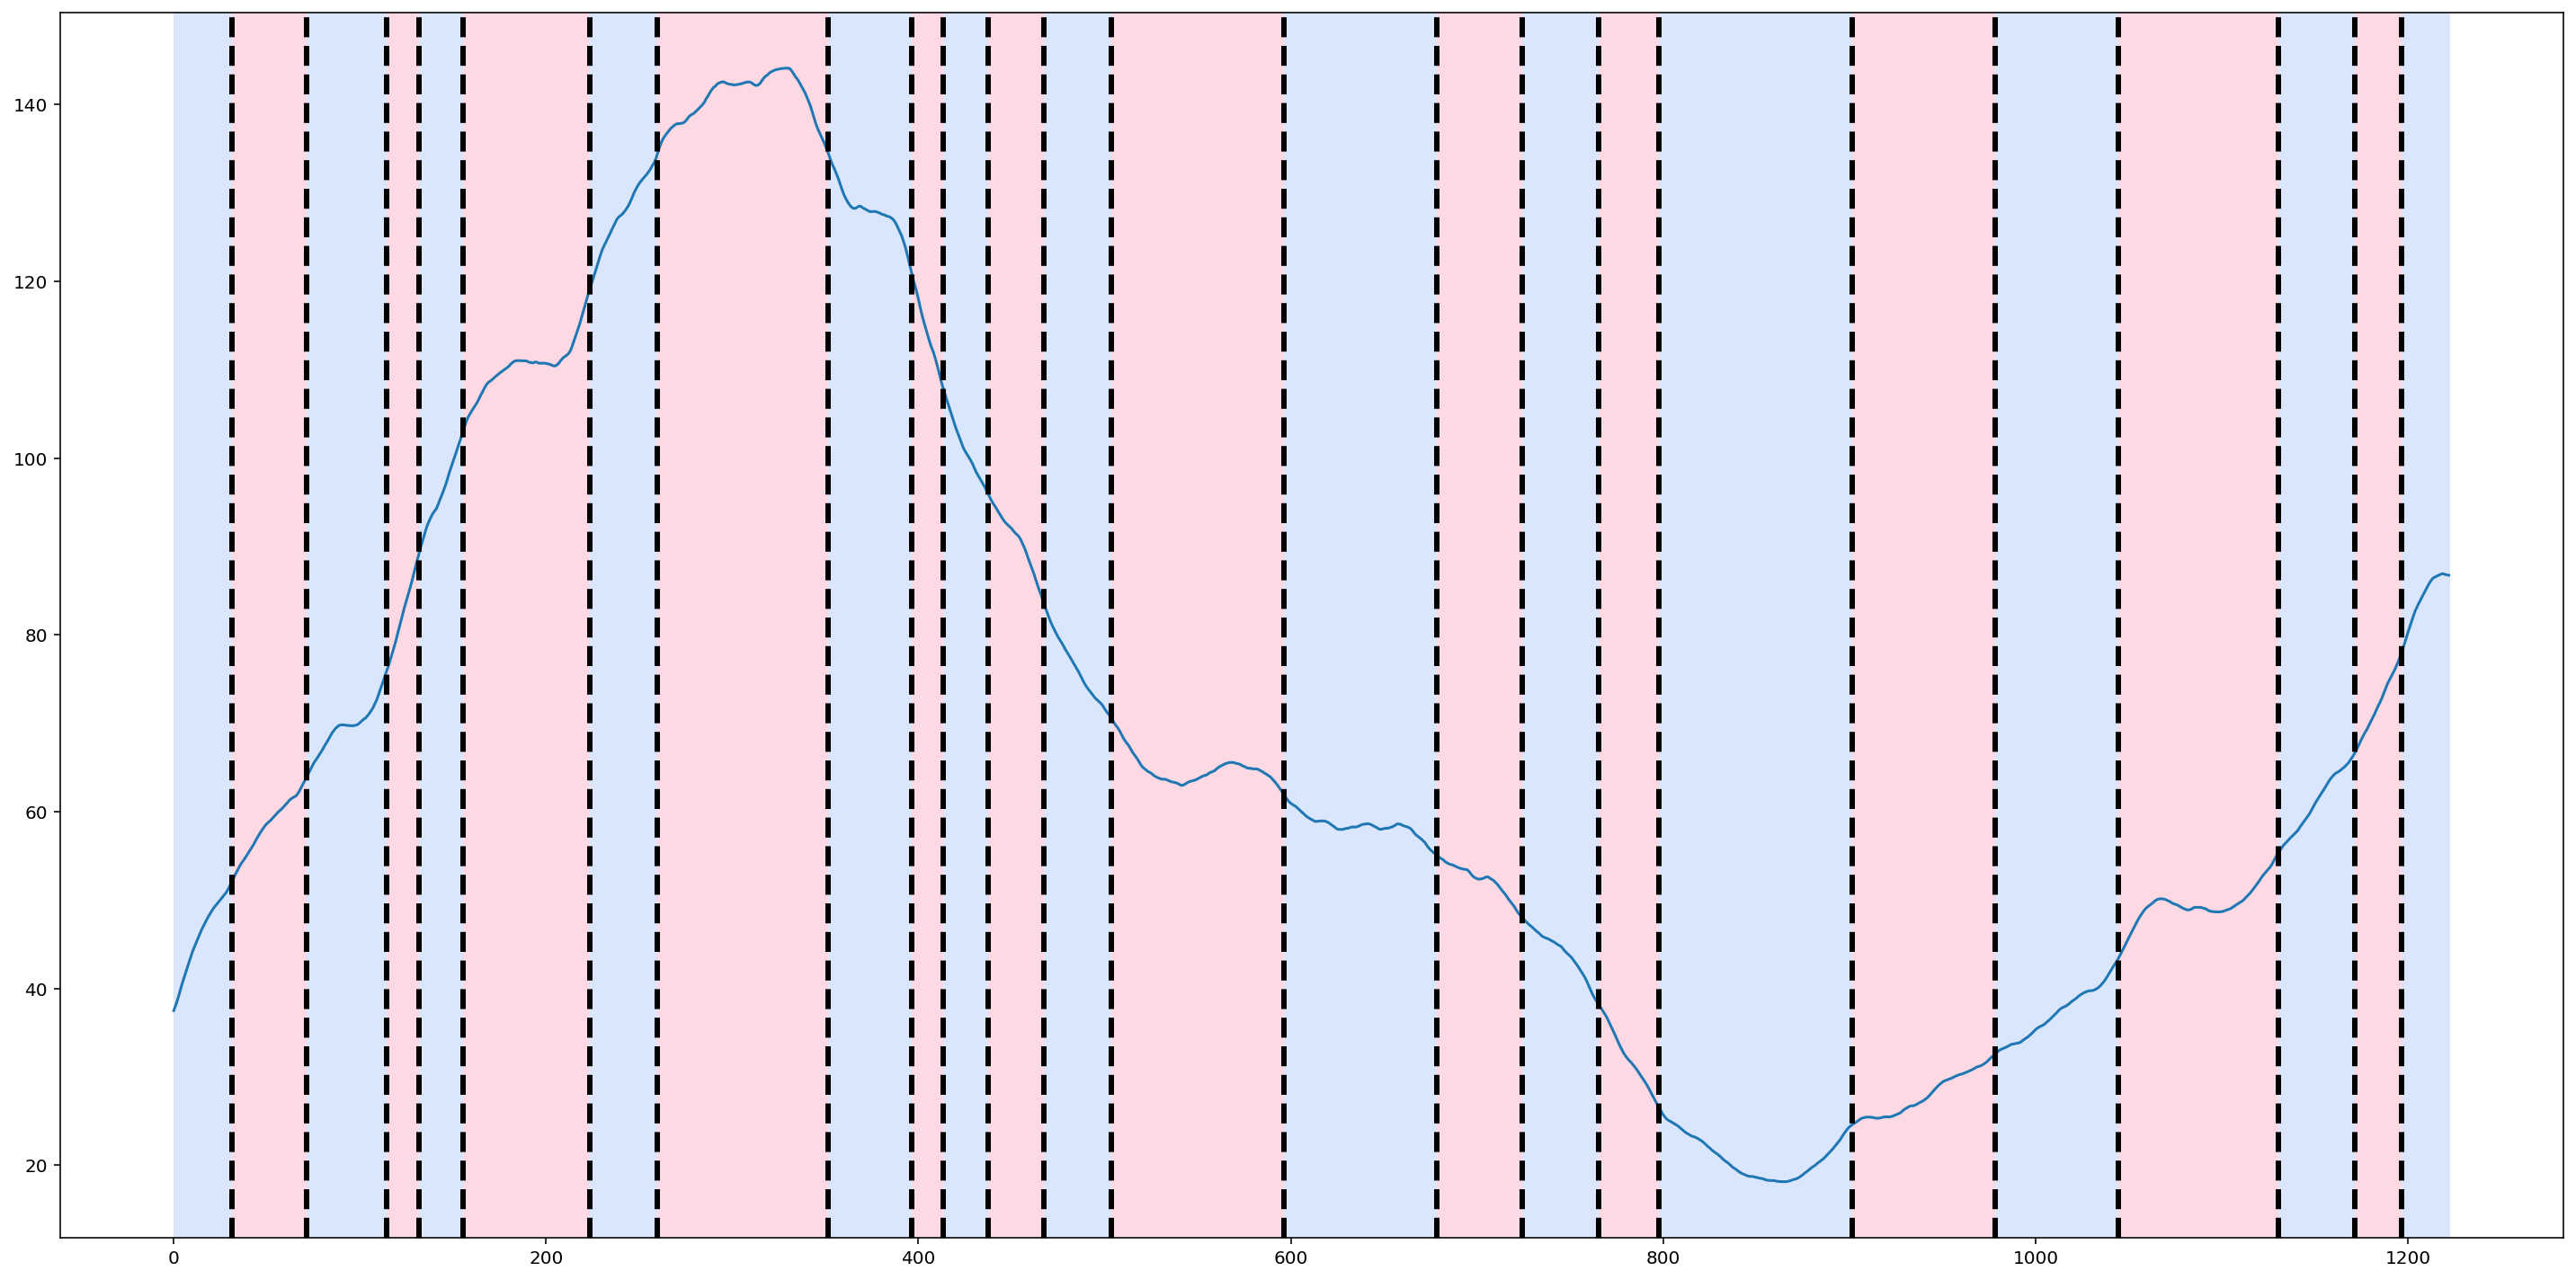

In [12]:
model = "rbf"  # "l1", "l2"
algo_red = rpt.Pelt(model=model, jump=1).fit(np.array(CIR_red))
bkps_red = algo_red.predict(pen=1)

fig = rpt.display(np.array(CIR_red), bkps_red, bkps_red, figsize=(20, 10))

if bkps_red[-1] == interest_rates.shape[0]:
    bkps_red = bkps_red[:-1]

bkps_red_ = [0] * interest_rates.shape[0]
for i in bkps_red:
    bkps_red_[i] = 1
CIR_red_data = pd.DataFrame(list(zip(interest_rates['date'], CIR_red, bkps_red_)), columns=['date', 'interest_rate', 'breakpoint'])

plt.show()

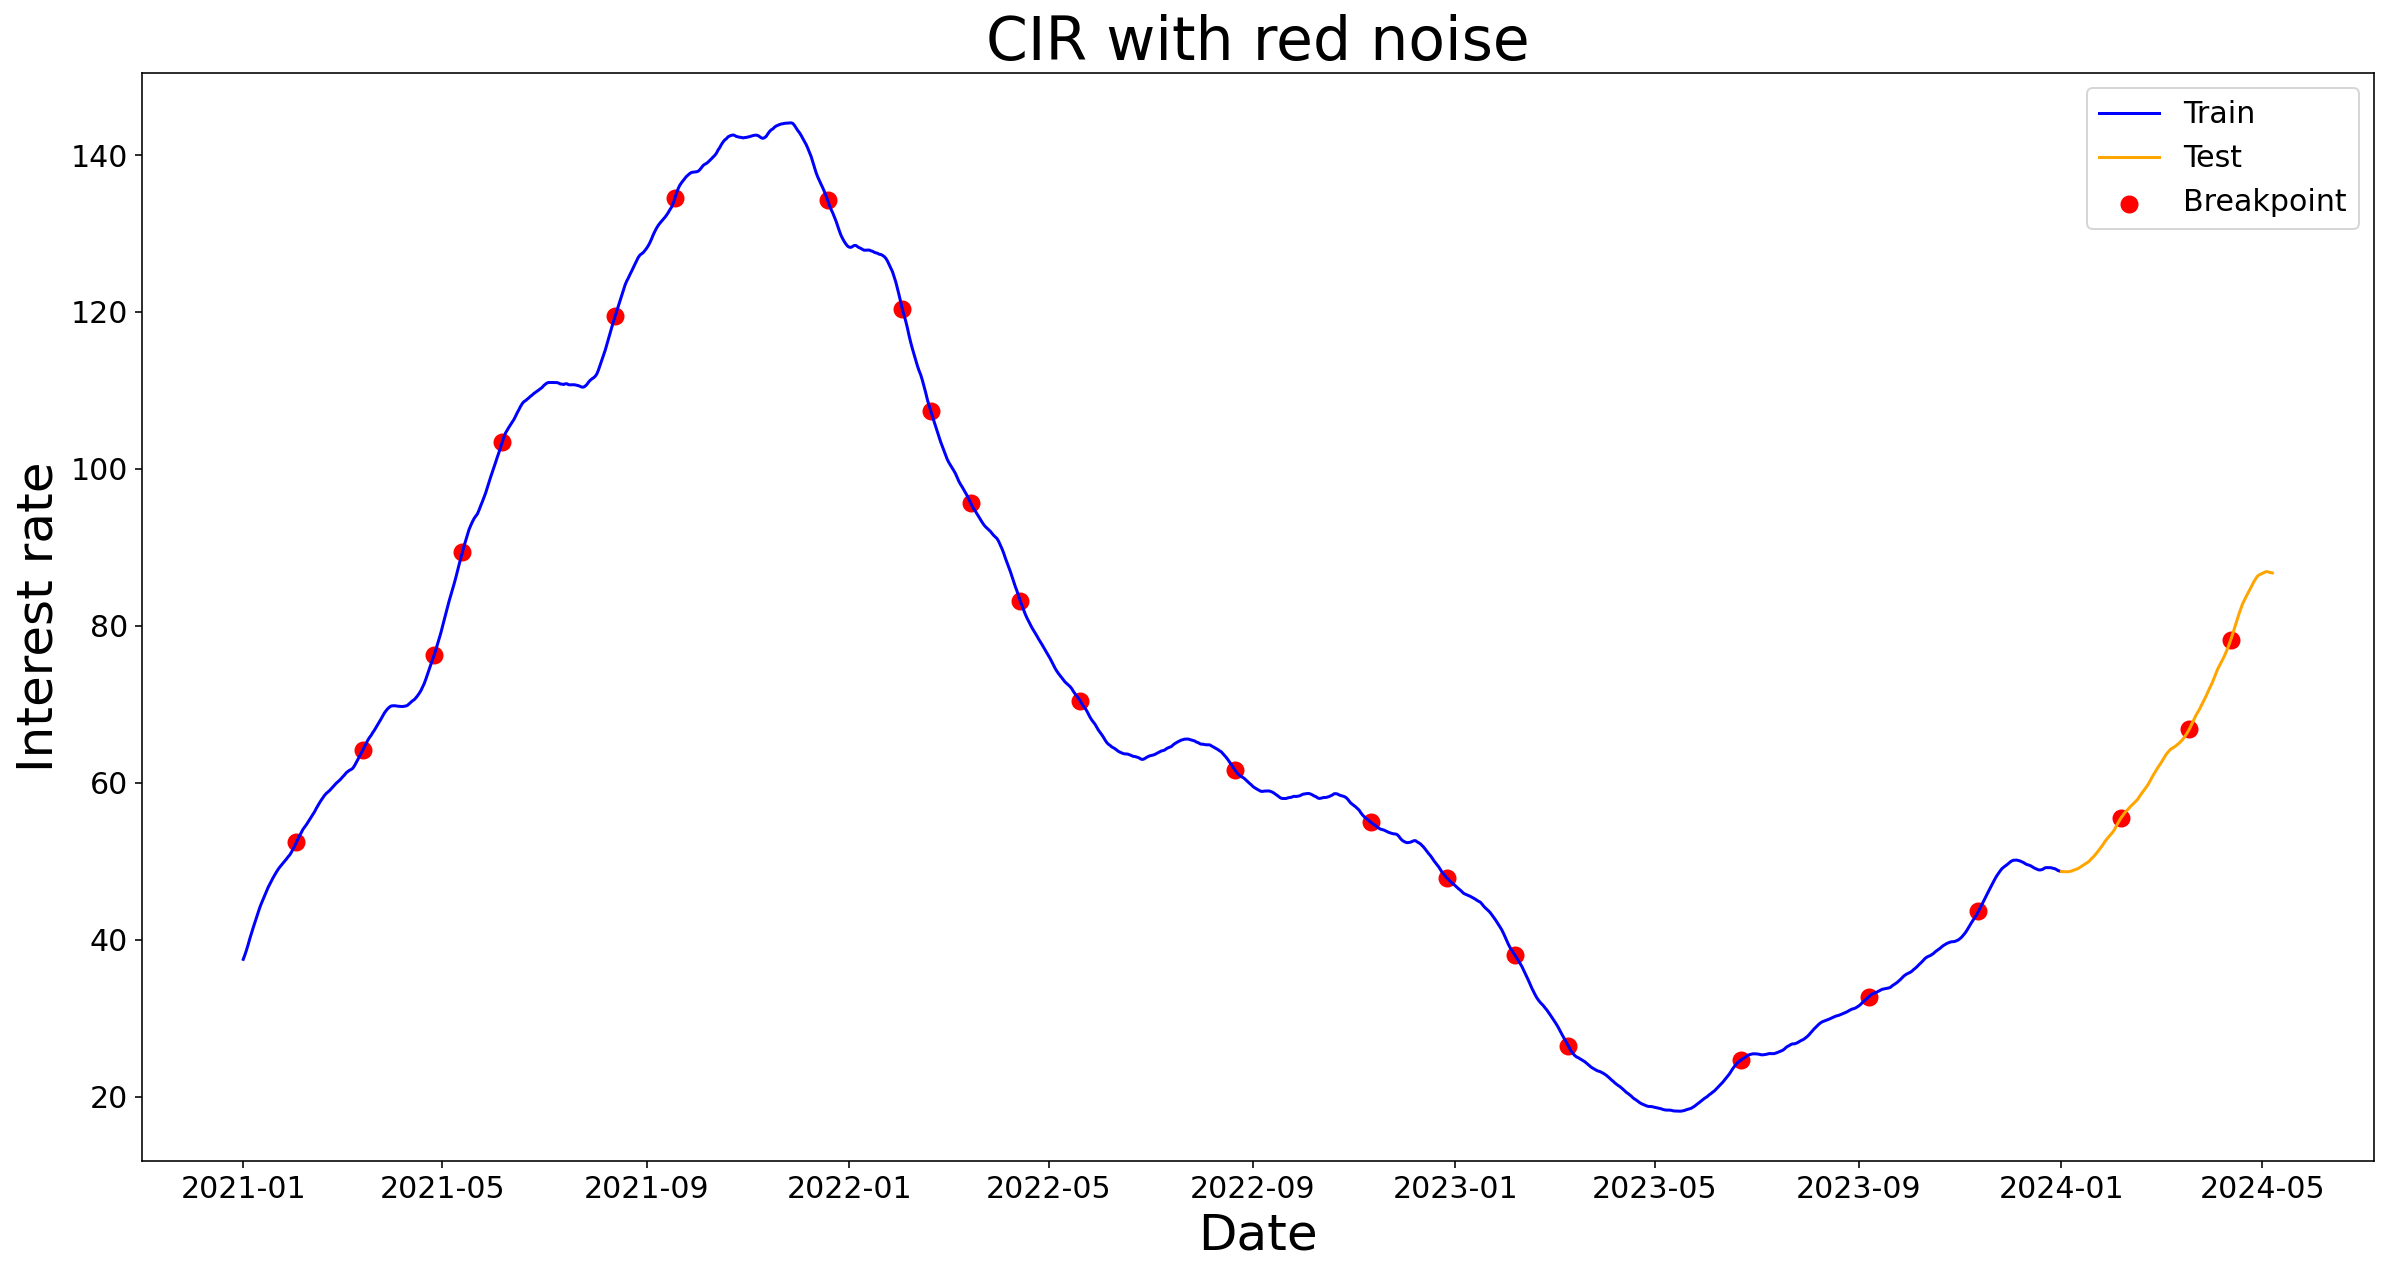

In [13]:
plt.scatter(CIR_red_data[CIR_red_data['breakpoint'] == 1]['date'], CIR_red_data[CIR_red_data['breakpoint'] == 1]['interest_rate'], color='red', linewidths=3, label='Breakpoint')
plt.plot(train['date'], CIR_red[:train.shape[0]], color='blue', label='Train')
plt.plot(test['date'], CIR_red[train.shape[0]:], color='orange', label='Test')
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('CIR with red noise', fontsize = 30)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

#### Blue noise ####

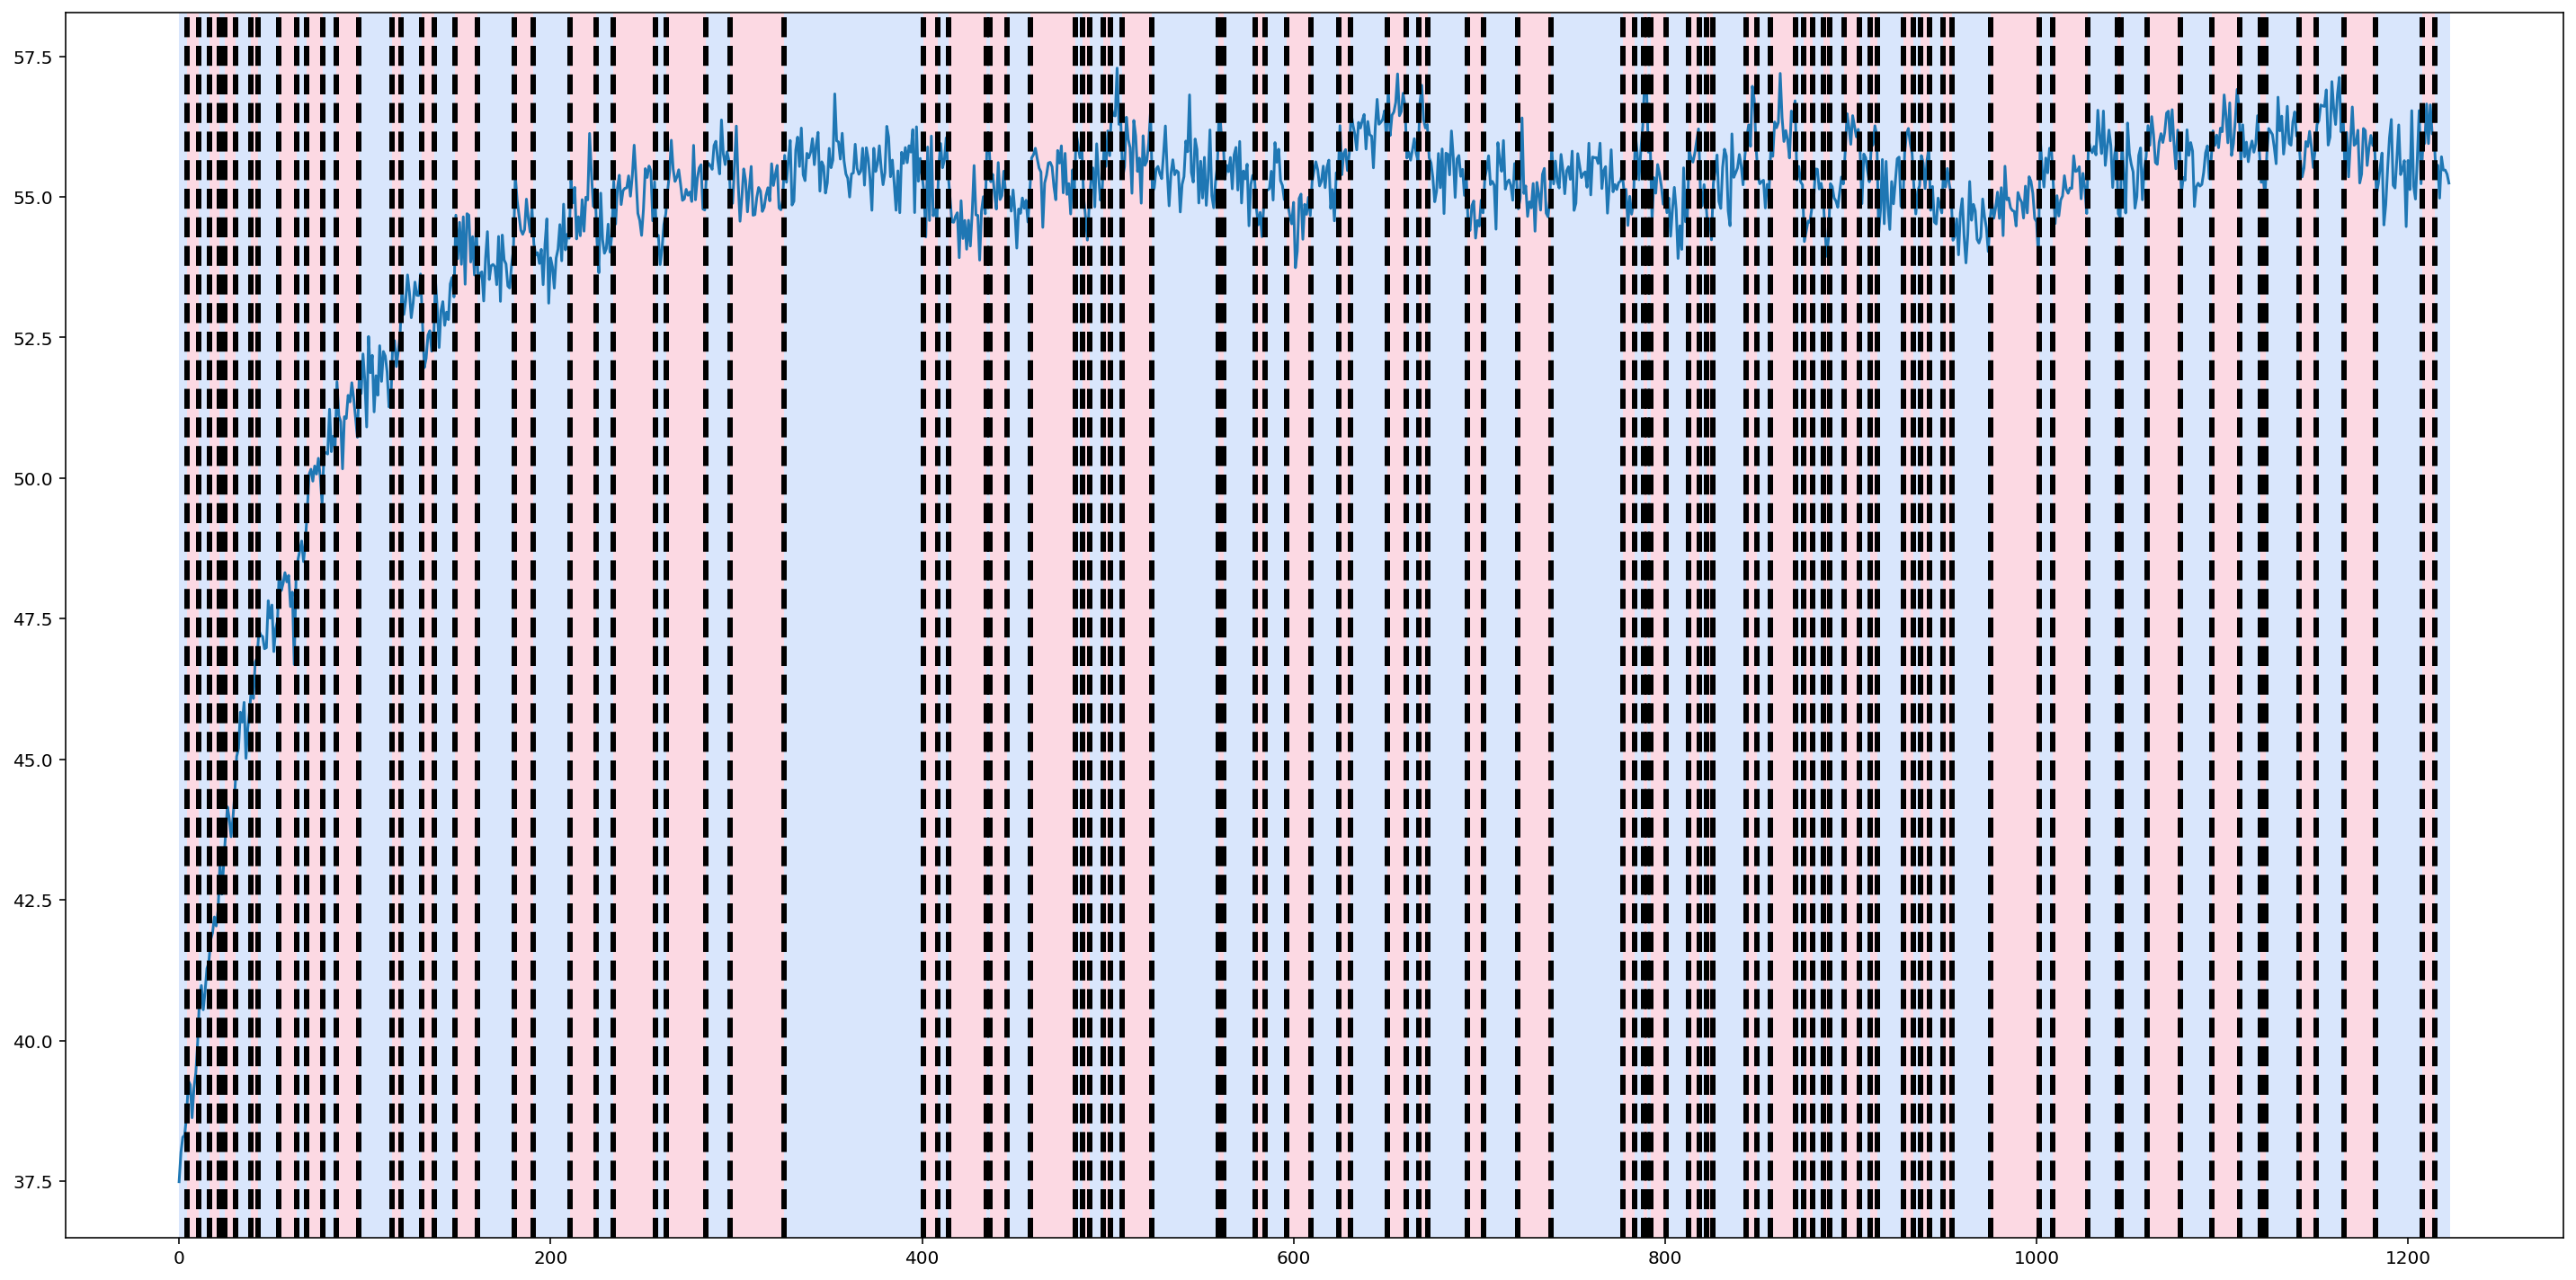

In [14]:
model = "rbf"  # "l1", "l2"
algo_blue = rpt.Pelt(model=model, jump=1).fit(np.array(CIR_blue))
bkps_blue = algo_blue.predict(pen=1)

fig = rpt.display(np.array(CIR_blue), bkps_blue, bkps_blue, figsize=(20, 10))

if bkps_blue[-1] == interest_rates.shape[0]:
    bkps_blue = bkps_blue[:-1]

bkps_blue_ = [0] * interest_rates.shape[0]
for i in bkps_blue:
    bkps_blue_[i] = 1
CIR_blue_data = pd.DataFrame(list(zip(interest_rates['date'], CIR_blue, bkps_blue_)), columns=['date', 'interest_rate', 'breakpoint'])

plt.show()

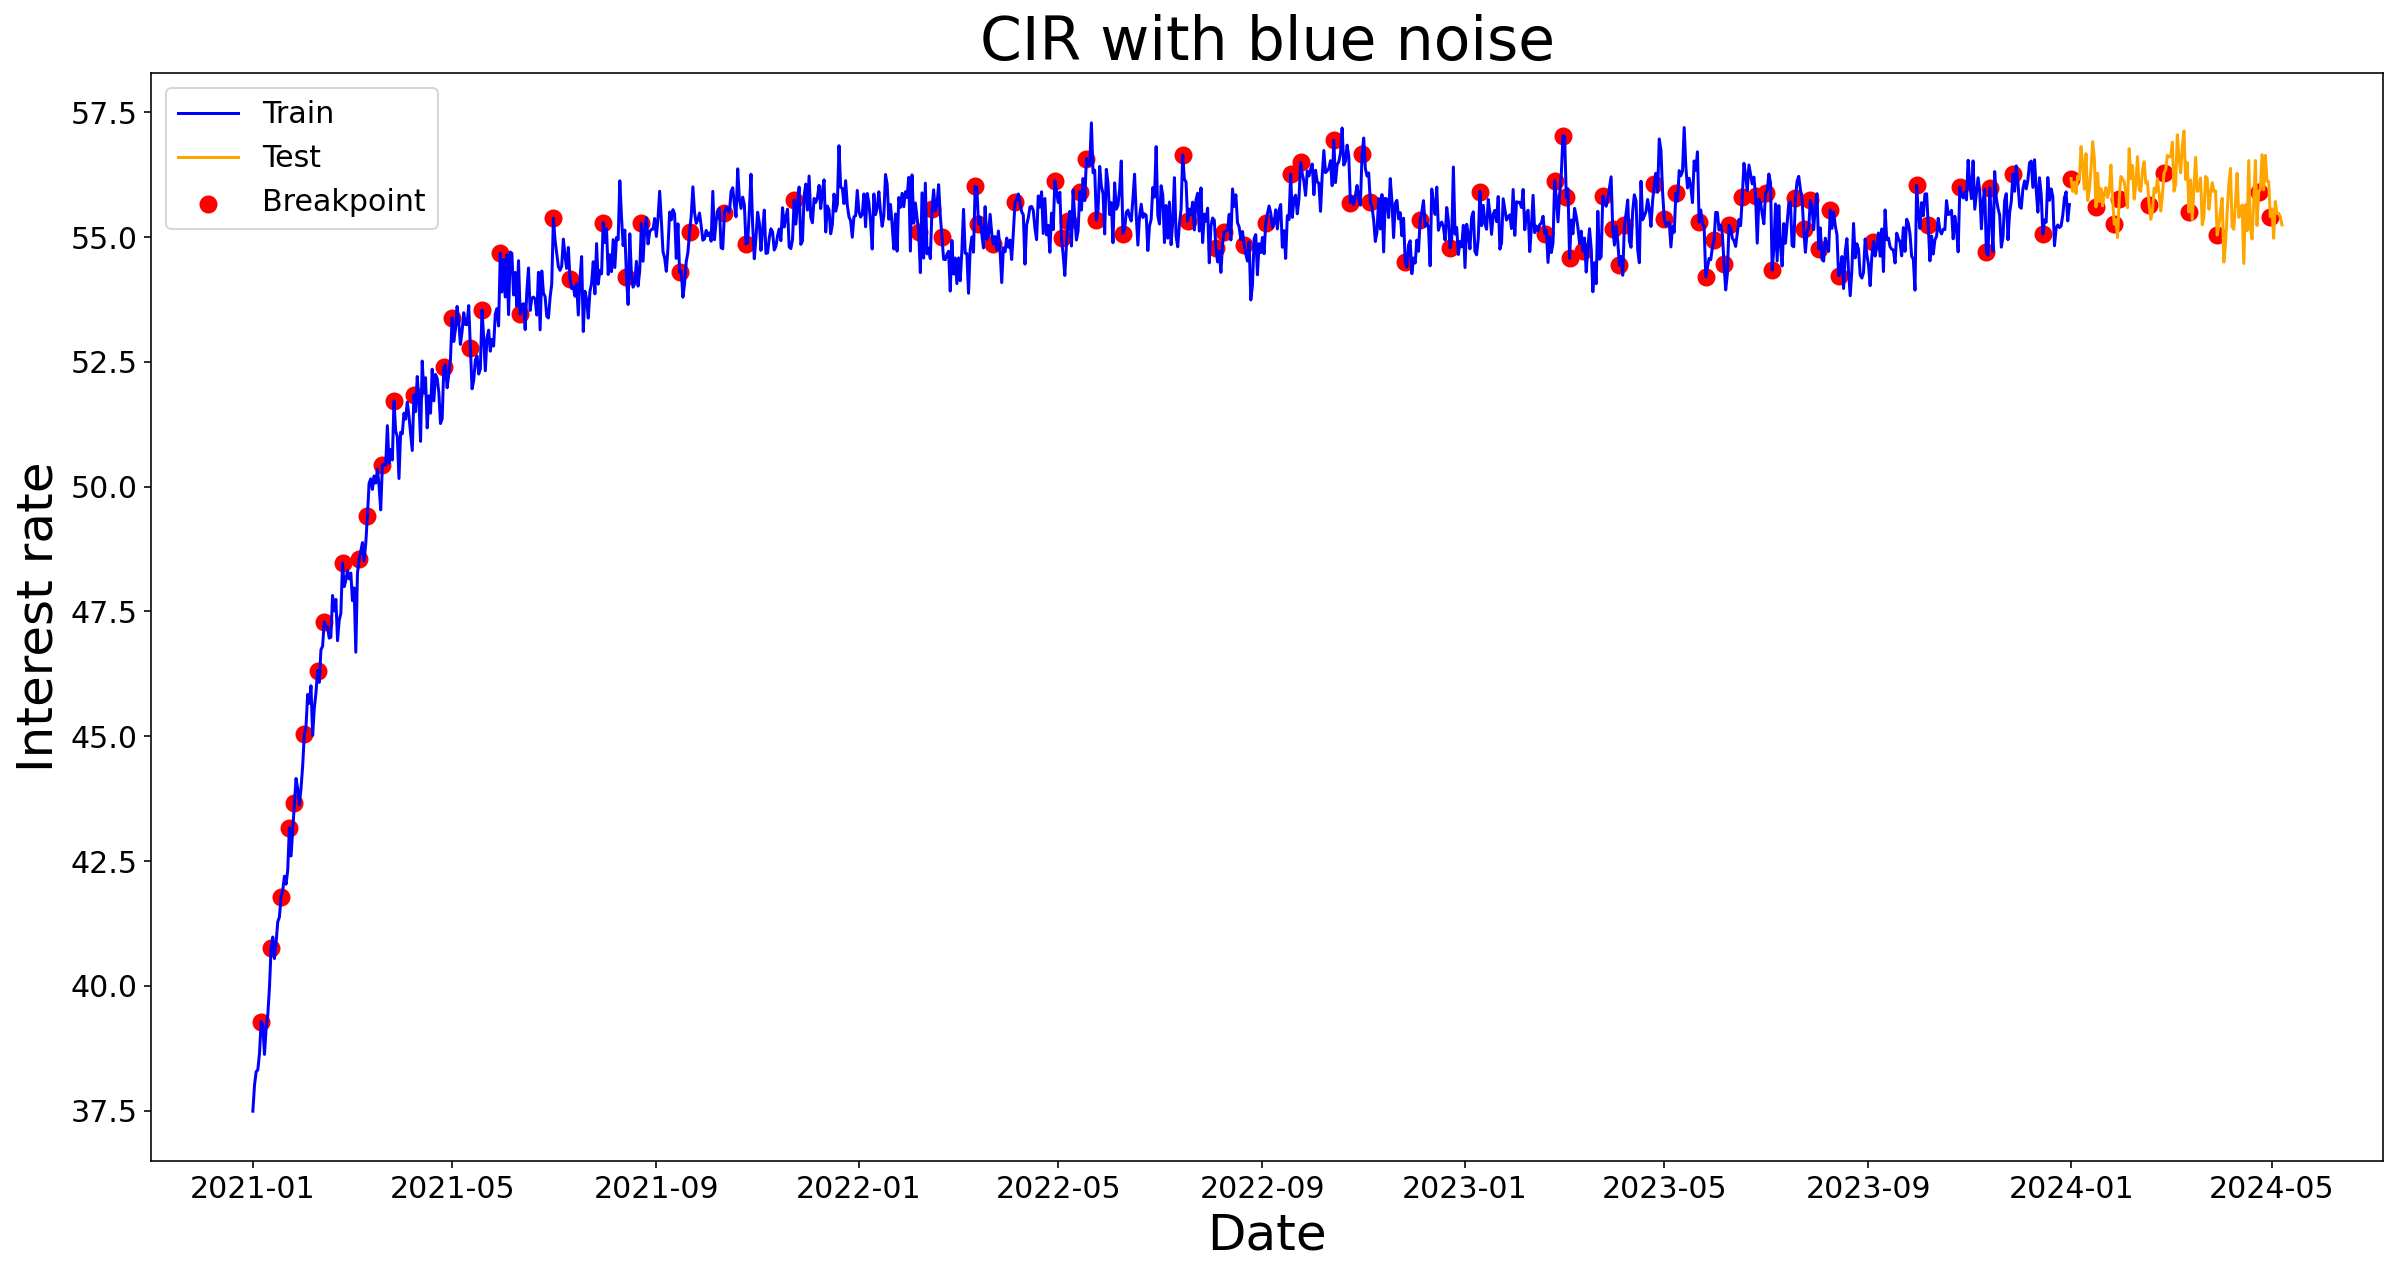

In [15]:
plt.scatter(CIR_blue_data[CIR_blue_data['breakpoint'] == 1]['date'], CIR_blue_data[CIR_blue_data['breakpoint'] == 1]['interest_rate'], color='red', linewidths=3, label='Breakpoint')
plt.plot(train['date'], CIR_blue[:train.shape[0]], color='blue', label='Train')
plt.plot(test['date'], CIR_blue[train.shape[0]:], color='orange', label='Test')
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('CIR with blue noise', fontsize = 30)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

#### Purple noise ####

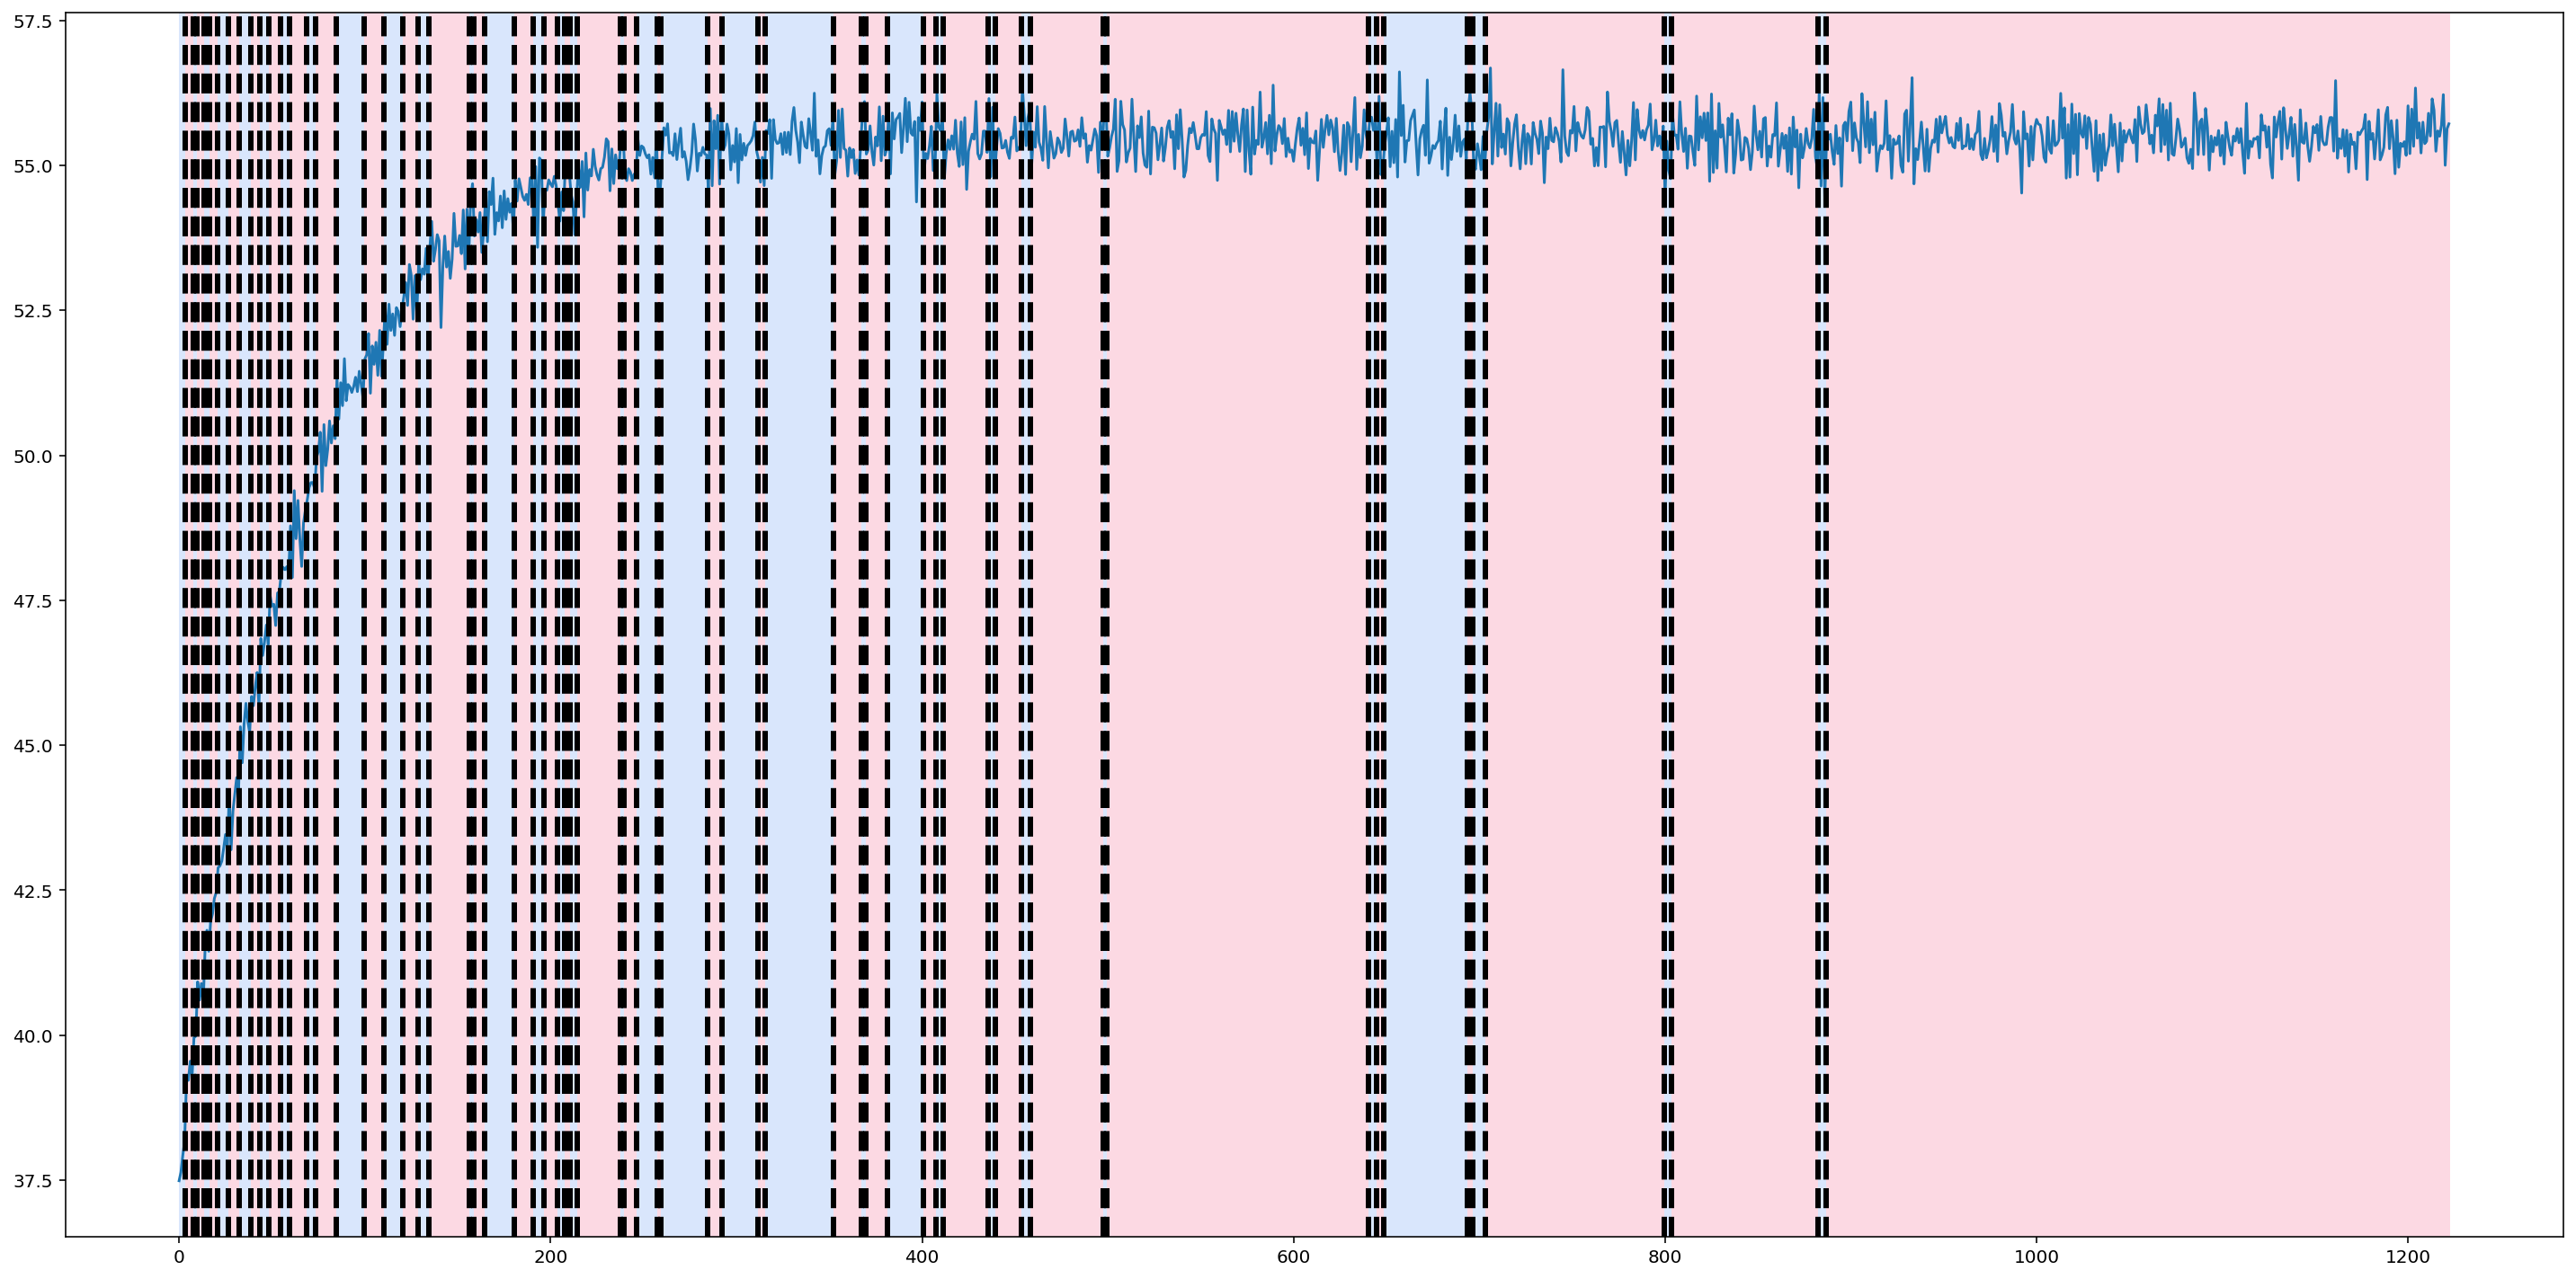

In [16]:
model = "rbf"  # "l1", "l2"
algo_purple = rpt.Pelt(model=model, jump=1).fit(np.array(CIR_purple))
bkps_purple = algo_purple.predict(pen=1)

fig = rpt.display(np.array(CIR_purple), bkps_purple, bkps_purple, figsize=(20, 10))

if bkps_purple[-1] == interest_rates.shape[0]:
    bkps_purple = bkps_purple[:-1]

bkps_purple_ = [0] * interest_rates.shape[0]
for i in bkps_purple:
    bkps_purple_[i] = 1
CIR_purple_data = pd.DataFrame(list(zip(interest_rates['date'], CIR_purple, bkps_purple_)), columns=['date', 'interest_rate', 'breakpoint'])

plt.show()

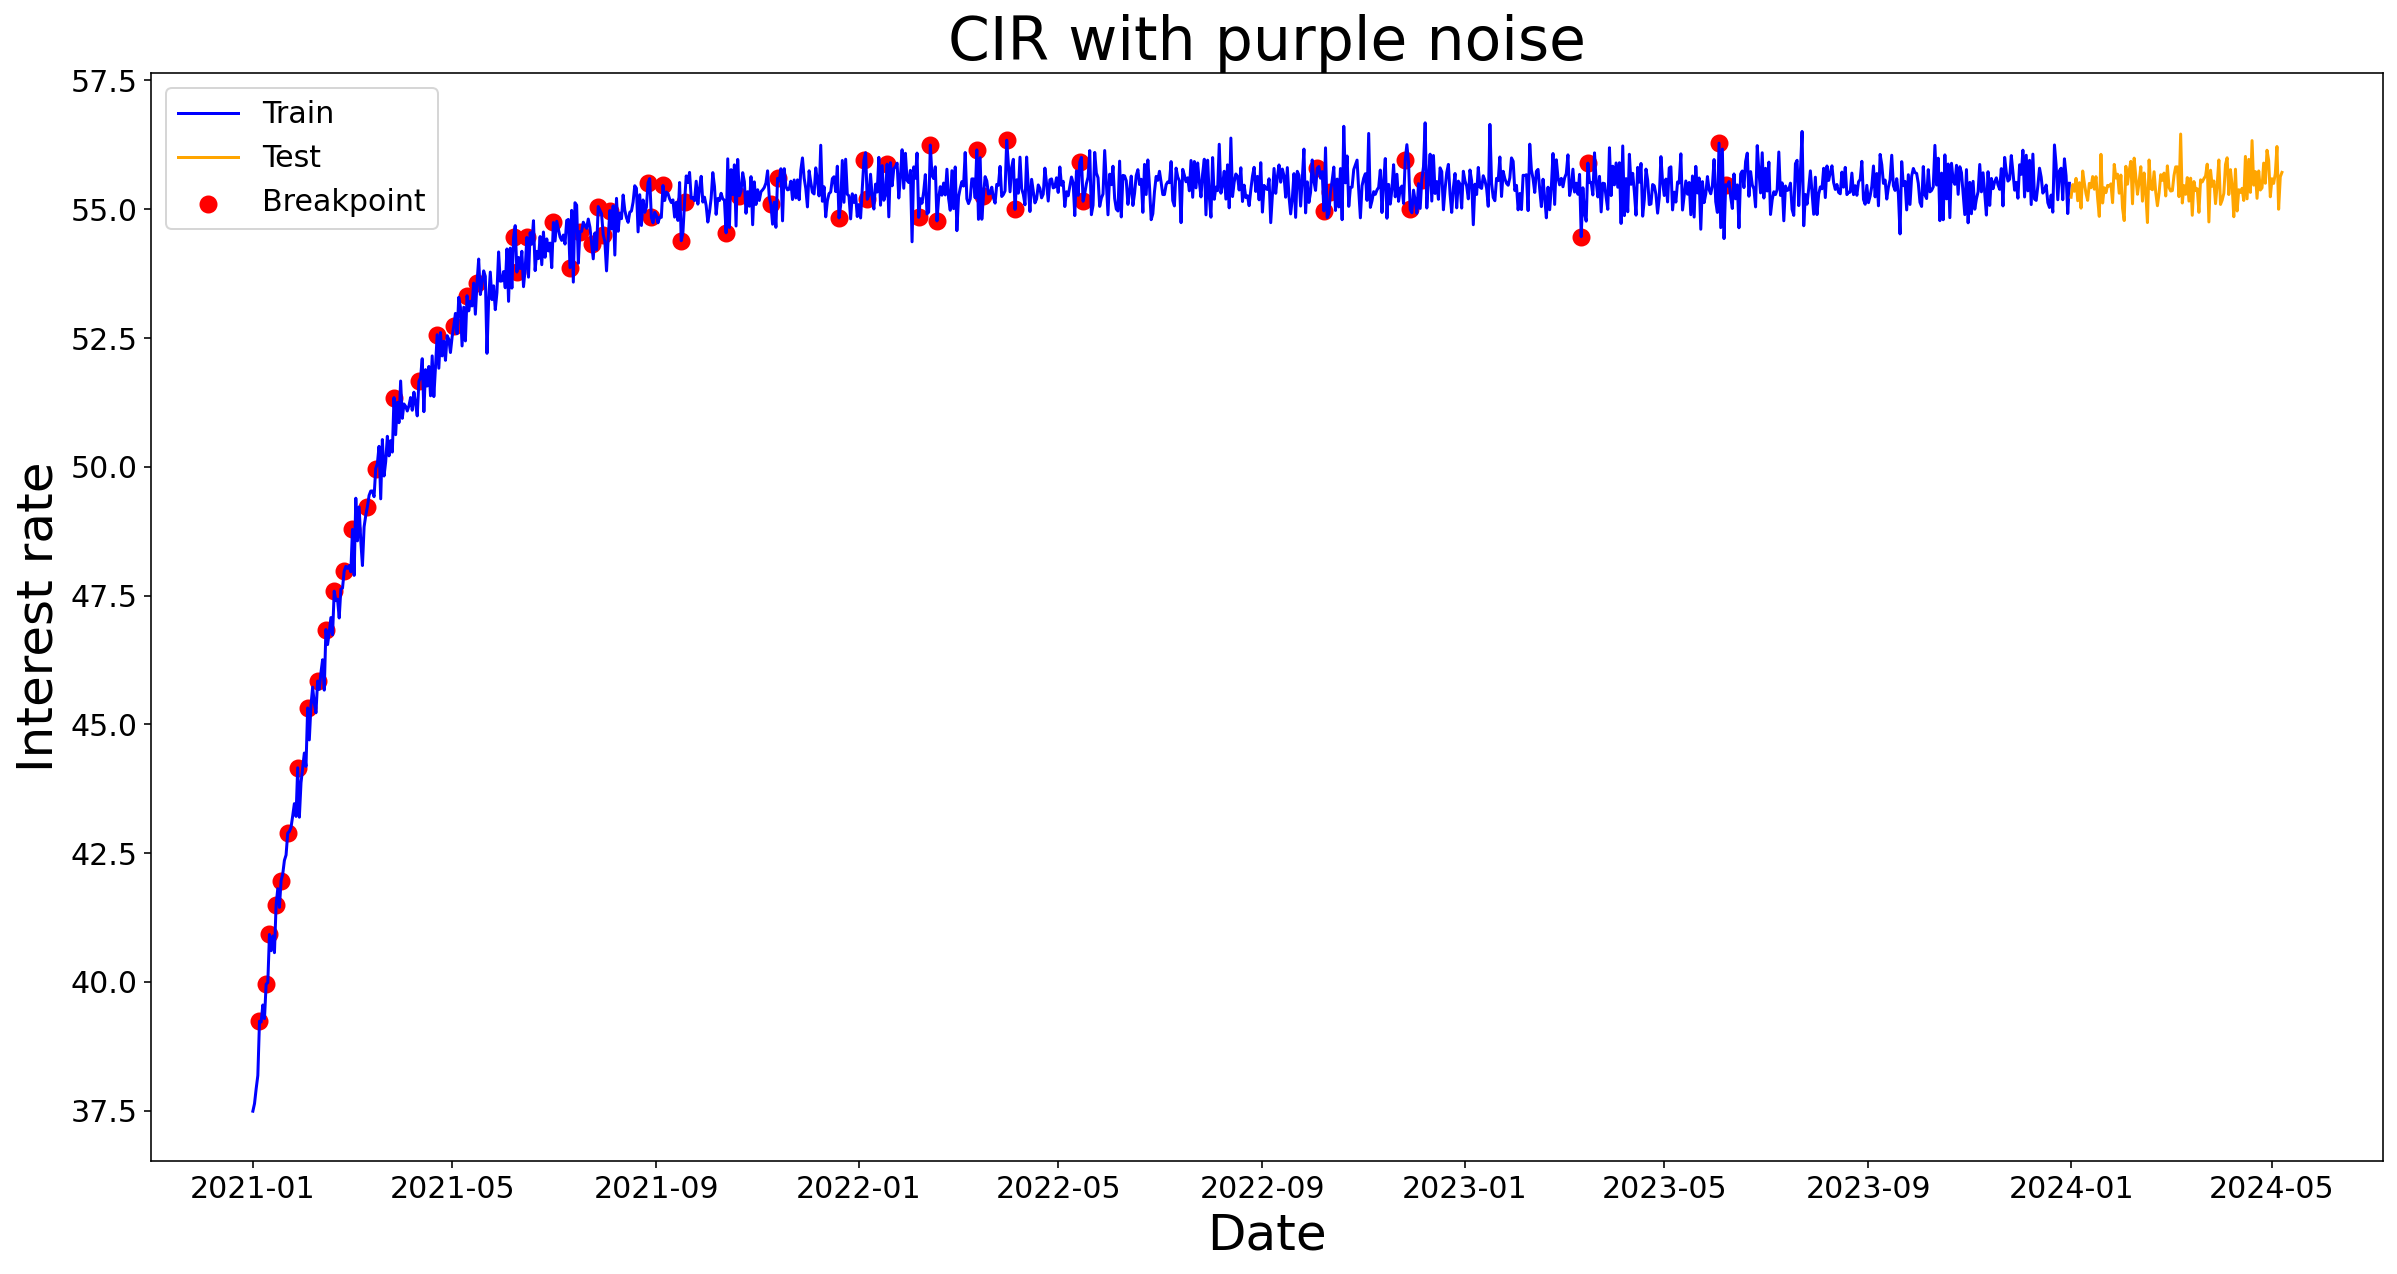

In [17]:
plt.scatter(CIR_purple_data[CIR_purple_data['breakpoint'] == 1]['date'], CIR_purple_data[CIR_purple_data['breakpoint'] == 1]['interest_rate'], color='red', linewidths=3, label='Breakpoint')
plt.plot(train['date'], CIR_purple[:train.shape[0]], color='blue', label='Train')
plt.plot(test['date'], CIR_purple[train.shape[0]:], color='orange', label='Test')
plt.xlabel('Date', fontsize = 25)
plt.ylabel('Interest rate', fontsize = 25)
plt.title('CIR with purple noise', fontsize = 30)
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [18]:
with pd.ExcelWriter('CIR.xlsx', engine='xlsxwriter') as writer:
    CIR_white_data.to_excel(writer, sheet_name='CIR_white', index=False)
    CIR_pink_data.to_excel(writer, sheet_name='CIR_pink', index=False)
    CIR_red_data.to_excel(writer, sheet_name='CIR_red', index=False)
    CIR_blue_data.to_excel(writer, sheet_name='CIR_blue', index=False)
    CIR_purple_data.to_excel(writer, sheet_name='CIR_purple', index=False)